In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

# Configuration
CLUSTERED_DATA_PATH = 'clustering_data.csv'
N_CLUSTERS = 10
SAMPLE_SIZE = 500000
RANDOM_STATE = 42

In [19]:
# Custom UTM conversion function for Iran
import utm
from functools import lru_cache

@lru_cache(maxsize=10000)
def iran_latlon_to_utm(lat, lon):
    """
    Convert latitude/longitude to UTM for Iran with proper zone handling
    """
    try:
        # Iran spans UTM zones 38N, 39N, 40N, 41N
        # Auto-detect zone based on longitude
        easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
        return easting, northing, zone_number, zone_letter
    except Exception as e:
        return np.nan, np.nan, np.nan, np.nan

def load_and_prepare_data(file_path):
    """
    Load data and prepare UTM coordinates
    """
    print("Loading and preparing data...")
    data = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    
    print(f"Original data shape: {data.shape}")
    print(f"Columns: {list(data.columns)}")
    
    # Convert geographic coordinates to UTM
    if 'location_latitude' in data.columns and 'location_longitude' in data.columns:
        print("\nConverting coordinates to UTM...")
        
        # Convert each coordinate
        utm_data = []
        for idx, row in data.iterrows():
            if pd.notna(row['location_latitude']) and pd.notna(row['location_longitude']):
                easting, northing, zone_num, zone_letter = iran_latlon_to_utm(
                    row['location_latitude'], 
                    row['location_longitude']
                )
                utm_data.append((easting, northing, zone_num, zone_letter))
            else:
                utm_data.append((np.nan, np.nan, np.nan, np.nan))
        
        # Add UTM columns
        data['utm_easting'] = [x[0] for x in utm_data]
        data['utm_northing'] = [x[1] for x in utm_data]
        data['utm_zone'] = [f"{int(x[2])}{x[3]}" if not np.isnan(x[2]) else np.nan for x in utm_data]
        
        # Remove points that couldn't be converted
        initial_count = len(data)
        data = data.dropna(subset=['utm_easting', 'utm_northing'])
        final_count = len(data)
        
        print(f"Successfully converted {final_count}/{initial_count} points to UTM")
        print(f"UTM zones: {data['utm_zone'].value_counts().to_dict()}")
    else:
        print("Warning: Geographic coordinates not found in data")
    
    return data

# Load the data
data = load_and_prepare_data(CLUSTERED_DATA_PATH)

Loading and preparing data...
Original data shape: (566444, 25)
Columns: ['cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

Converting coordinates to UTM...
Successfully converted 566444/566444 points to UTM
UTM zones: {'39S': 455876, '40S': 34709, '38S': 31392, '39R': 28754, '40R': 12192, '41R': 3209, '41S': 284, '38R': 20, '40Q': 4, '39Q': 2, '37S': 1, '38T': 1}


In [20]:
# اول بررسی کنیم مشکل کجاست
print("Debugging feature creation...")

# دوباره features را می‌سازیم اما با debug
def debug_feature_creation(df):
    """تابع debug برای بررسی مشکل"""
    print(f"Input data shape: {df.shape}")
    
    # بررسی missing values
    missing_counts = df.isnull().sum()
    print(f"\nMissing values per column:")
    print(missing_counts[missing_counts > 0])
    
    # تست هر ستون
    test_features = []
    
    # 1. UTM coordinates
    if 'utm_easting' in df.columns:
        print(f"\nutm_easting stats:")
        print(f"  Total: {len(df['utm_easting'])}")
        print(f"  Not null: {df['utm_easting'].notnull().sum()}")
        print(f"  Null: {df['utm_easting'].isnull().sum()}")
        test_features.append('utm_easting')
    
    if 'utm_northing' in df.columns:
        print(f"\nutm_northing stats:")
        print(f"  Total: {len(df['utm_northing'])}")
        print(f"  Not null: {df['utm_northing'].notnull().sum()}")
        print(f"  Null: {df['utm_northing'].isnull().sum()}")
        test_features.append('utm_northing')
    
    # 2. Price
    if 'price_value' in df.columns:
        print(f"\nprice_value stats:")
        print(f"  Total: {len(df['price_value'])}")
        print(f"  Not null: {df['price_value'].notnull().sum()}")
        print(f"  Null: {df['price_value'].isnull().sum()}")
        test_features.append('price_value')
    
    # 3. Building size
    if 'building_size' in df.columns:
        print(f"\nbuilding_size stats:")
        print(f"  Total: {len(df['building_size'])}")
        print(f"  Not null: {df['building_size'].notnull().sum()}")
        print(f"  Null: {df['building_size'].isnull().sum()}")
        test_features.append('building_size')
    
    return test_features

# اجرای debug
debug_features = debug_feature_creation(data)

Debugging feature creation...
Input data shape: (566444, 28)

Missing values per column:
has_balcony    104
dtype: int64

utm_easting stats:
  Total: 566444
  Not null: 566444
  Null: 0

utm_northing stats:
  Total: 566444
  Not null: 566444
  Null: 0

price_value stats:
  Total: 566444
  Not null: 566444
  Null: 0

building_size stats:
  Total: 566444
  Not null: 566444
  Null: 0


In [21]:
def create_safe_features(df, sample_size=50000):
    """
    تابع امن برای ایجاد features بدون حذف تمام داده‌ها
    """
    print("\nCreating safe features...")
    
    # Sample data if too large
    if len(df) > sample_size:
        df_sample = df.sample(n=min(sample_size, len(df)), random_state=RANDOM_STATE)
        print(f"Sampled {len(df_sample)} rows from {len(df)}")
    else:
        df_sample = df.copy()
    
    # Initialize feature list and data
    features = []
    feature_data = {}
    
    # List of columns to check
    columns_to_check = [
        'utm_easting', 'utm_northing', 'price_value', 
        'building_size', 'rooms_count', 'property_type_encoded'
    ]
    
    print("Checking available columns...")
    available_cols = [col for col in columns_to_check if col in df_sample.columns]
    print(f"Available columns: {available_cols}")
    
    # 1. Basic features with imputation
    if 'utm_easting' in df_sample.columns:
        # Fill NaN with median
        easting_clean = df_sample['utm_easting'].fillna(df_sample['utm_easting'].median())
        feature_data['utm_easting'] = easting_clean
        features.append('utm_easting')
    
    if 'utm_northing' in df_sample.columns:
        # Fill NaN with median
        northing_clean = df_sample['utm_northing'].fillna(df_sample['utm_northing'].median())
        feature_data['utm_northing'] = northing_clean
        features.append('utm_northing')
    
    # 2. Price feature with transformation
    if 'price_value' in df_sample.columns:
        # Fill NaN with median
        price_filled = df_sample['price_value'].fillna(df_sample['price_value'].median())
        # Clip extreme values
        q1 = price_filled.quantile(0.01)
        q99 = price_filled.quantile(0.99)
        price_clipped = price_filled.clip(q1, q99)
        # Log transform
        price_transformed = np.log1p(price_clipped)
        feature_data['log_price'] = price_transformed
        features.append('log_price')
        print(f"Price transformation: min={price_transformed.min():.2f}, max={price_transformed.max():.2f}")
    
    # 3. Building size
    if 'building_size' in df_sample.columns:
        # Fill NaN with median
        size_filled = df_sample['building_size'].fillna(df_sample['building_size'].median())
        # Clip outliers
        q1_size = size_filled.quantile(0.01)
        q99_size = size_filled.quantile(0.99)
        size_clean = size_filled.clip(q1_size, q99_size)
        feature_data['building_size'] = size_clean
        features.append('building_size')
    
    # 4. Rooms count (handle if it's categorical)
    if 'rooms_count' in df_sample.columns:
        try:
            # Convert to numeric if needed
            rooms_numeric = pd.to_numeric(df_sample['rooms_count'], errors='coerce')
            rooms_filled = rooms_numeric.fillna(rooms_numeric.median())
            feature_data['rooms_count'] = rooms_filled
            features.append('rooms_count')
        except Exception as e:
            print(f"Could not convert rooms_count: {e}")
    
    # 5. Property type encoded
    if 'property_type_encoded' in df_sample.columns:
        prop_filled = df_sample['property_type_encoded'].fillna(df_sample['property_type_encoded'].median())
        feature_data['property_type'] = prop_filled
        features.append('property_type')
    
    # 6. Amenities score (sum of boolean features)
    amenity_cols = [col for col in df_sample.columns if col.startswith('has_')]
    if amenity_cols:
        print(f"Found amenity columns: {len(amenity_cols)}")
        amenities_score = pd.Series(0, index=df_sample.index)
        for col in amenity_cols[:5]:  # Take first 5 to avoid too many
            # Convert to numeric
            if col in df_sample.columns:
                col_series = df_sample[col]
                # Map different formats to 0/1
                col_numeric = col_series.map({'true': 1, 'True': 1, True: 1, 
                                              'false': 0, 'False': 0, False: 0, 
                                              np.nan: 0, None: 0})
                # If mapping failed, try direct conversion
                if col_numeric.isnull().any():
                    col_numeric = pd.to_numeric(col_series, errors='coerce').fillna(0)
                
                amenities_score += col_numeric
        
        feature_data['amenities'] = amenities_score
        features.append('amenities')
    
    # Create feature matrix
    if features:
        X = pd.DataFrame(feature_data)[features]
        print(f"\nCreated {len(features)} features:")
        print(features)
        print(f"Feature matrix shape: {X.shape}")
        print(f"Missing values in X: {X.isnull().sum().sum()}")
        
        # Fill any remaining NaN with column means
        if X.isnull().sum().sum() > 0:
            print("Filling remaining NaN with column means...")
            X = X.fillna(X.mean())
    else:
        print("No features created!")
        # Create dummy features as fallback
        X = pd.DataFrame({
            'dummy1': np.random.randn(len(df_sample)),
            'dummy2': np.random.randn(len(df_sample))
        })
        features = ['dummy1', 'dummy2']
    
    return X, features, df_sample

# تست تابع اصلاح‌شده
print("\nTesting safe feature creation...")
X_safe, features_safe, data_safe = create_safe_features(data)
print(f"\nSafe X shape: {X_safe.shape}")
print(f"Features: {features_safe}")


Testing safe feature creation...

Creating safe features...
Sampled 50000 rows from 566444
Checking available columns...
Available columns: ['utm_easting', 'utm_northing', 'price_value', 'building_size', 'rooms_count', 'property_type_encoded']
Price transformation: min=11.62, max=25.17
Found amenity columns: 5

Created 7 features:
['utm_easting', 'utm_northing', 'log_price', 'building_size', 'rooms_count', 'property_type', 'amenities']
Feature matrix shape: (50000, 7)
Missing values in X: 0

Safe X shape: (50000, 7)
Features: ['utm_easting', 'utm_northing', 'log_price', 'building_size', 'rooms_count', 'property_type', 'amenities']


In [22]:
def create_enhanced_features(df, sample_size=50000):
    """
    Create enhanced features with better preprocessing
    """
    print("\nCreating enhanced features...")
    
    # Sample data if too large
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=RANDOM_STATE, weights='price_value' if 'price_value' in df.columns else None)
        print(f"Sampled {len(df_sample)} rows from {len(df)}")
    else:
        df_sample = df.copy()
    
    # Initialize feature list
    features = []
    feature_data = {}
    
    # 1. Geographic features (UTM)
    if 'utm_easting' in df_sample.columns:
        # Winsorize UTM coordinates to remove extreme outliers
        for col in ['utm_easting', 'utm_northing']:
            q1 = df_sample[col].quantile(0.01)
            q99 = df_sample[col].quantile(0.99)
            feature_data[f'{col}_clean'] = df_sample[col].clip(q1, q99)
            features.append(f'{col}_clean')
    
    # 2. Price features with better transformation
    if 'price_value' in df_sample.columns:
        # Remove extreme outliers (top/bottom 1%)
        price_q1 = df_sample['price_value'].quantile(0.01)
        price_q99 = df_sample['price_value'].quantile(0.99)
        price_clean = df_sample['price_value'].clip(price_q1, price_q99)
        
        # Apply Yeo-Johnson like transformation (more robust than log)
        price_transformed = np.log1p(price_clean)
        feature_data['price_transformed'] = price_transformed
        features.append('price_transformed')
    
    # 3. Building features
    if 'building_size' in df_sample.columns:
        # Handle outliers and normalize
        size_q1 = df_sample['building_size'].quantile(0.01)
        size_q99 = df_sample['building_size'].quantile(0.99)
        size_clean = df_sample['building_size'].clip(size_q1, size_q99)
        feature_data['building_size_clean'] = size_clean
        features.append('building_size_clean')
    
    # 4. Rooms count (if exists and is numeric)
    if 'rooms_count' in df_sample.columns:
        try:
            # Convert to numeric if needed
            rooms_numeric = pd.to_numeric(df_sample['rooms_count'], errors='coerce')
            feature_data['rooms_count_clean'] = rooms_numeric.fillna(rooms_numeric.median())
            features.append('rooms_count_clean')
        except:
            pass
    
    # 5. Amenities score (sum of boolean features)
    amenity_cols = [col for col in df_sample.columns if col.startswith('has_') and col in df_sample.columns]
    if amenity_cols:
        amenities_score = 0
        for col in amenity_cols:
            # Convert to numeric (0/1)
            col_numeric = df_sample[col].map({'true': 1, 'True': 1, True: 1, 'false': 0, 'False': 0, False: 0, np.nan: 0})
            amenities_score += col_numeric
        feature_data['amenities_score'] = amenities_score
        features.append('amenities_score')
    
    # 6. Property type encoded
    if 'property_type_encoded' in df_sample.columns:
        feature_data['property_type_encoded'] = df_sample['property_type_encoded']
        features.append('property_type_encoded')
    
    # 7. Create combined features
    if 'building_size_clean' in feature_data and 'rooms_count_clean' in feature_data:
        feature_data['size_per_room'] = feature_data['building_size_clean'] / feature_data['rooms_count_clean'].replace(0, 1)
        features.append('size_per_room')
    
    # Create feature matrix
    X = pd.DataFrame(feature_data)[features].dropna()
    
    print(f"Created {len(features)} features:")
    for feature in features:
        print(f"  - {feature}")
    
    print(f"\nFeature matrix shape: {X.shape}")
    
    return X, features, df_sample

In [23]:
def robust_kmeans_clustering(X, n_clusters=10):
    """
    تابع robust برای K-means clustering
    """
    print(f"\nPerforming robust K-means clustering with {n_clusters} clusters...")
    
    # 1. Basic validation
    if len(X) == 0:
        print("Error: Empty feature matrix!")
        return None, None, None, None, None
    
    if X.isnull().any().any():
        print("Warning: NaN values found, filling with column means...")
        X = X.fillna(X.mean())
    
    # 2. Standard scaling
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print(f"Successfully scaled data. Shape: {X_scaled.shape}")
    except Exception as e:
        print(f"Scaling failed: {e}")
        print("Using original data without scaling...")
        X_scaled = X.values
        scaler = None
    
    # 3. K-means clustering
    try:
        kmeans = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=20,
            max_iter=300,
            random_state=RANDOM_STATE,
            verbose=0
        )
        
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Calculate metrics
        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(X_scaled, cluster_labels)
            wcss = kmeans.inertia_
        else:
            silhouette_avg = 0
            wcss = 0
            
        print(f"\nClustering successful!")
        print(f"  Number of clusters found: {len(np.unique(cluster_labels))}")
        print(f"  Within-Cluster Sum of Squares (WCSS): {wcss:.2e}")
        print(f"  Silhouette Score: {silhouette_avg:.3f}")
        
        return kmeans, cluster_labels, scaler, None, X_scaled
        
    except Exception as e:
        print(f"Clustering failed: {e}")
        return None, None, None, None, None

In [24]:
def enhanced_kmeans_clustering(X, n_clusters=10, use_pca=True, pca_variance=0.95):
    """
    Perform enhanced K-means clustering with better initialization
    """
    print(f"\nPerforming enhanced K-means clustering with {n_clusters} clusters...")
    
    # 1. Robust Scaling (less sensitive to outliers)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Optional PCA for dimensionality reduction
    if use_pca and X_scaled.shape[1] > 5:
        print("Applying PCA for dimensionality reduction...")
        pca = PCA(n_components=pca_variance, random_state=RANDOM_STATE)
        X_transformed = pca.fit_transform(X_scaled)
        print(f"Reduced dimensions: {X_scaled.shape[1]} -> {X_transformed.shape[1]}")
        print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    else:
        X_transformed = X_scaled
        pca = None
    
    # 3. K-means with improved parameters
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',  # Better initialization
        n_init=50,  # More initializations
        max_iter=500,  # More iterations
        tol=1e-4,  # Tighter tolerance
        random_state=RANDOM_STATE,
        algorithm='elkan'  # More efficient for dense data
    )
    
    # Fit and predict
    cluster_labels = kmeans.fit_predict(X_transformed)
    
    # Calculate metrics
    wcss = kmeans.inertia_
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_transformed, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_transformed, cluster_labels)
    
    print("\nClustering Results:")
    print(f"  Within-Cluster Sum of Squares (WCSS): {wcss:.2e}")
    print(f"  Silhouette Score: {silhouette_avg:.3f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.3f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.3f}")
    
    return kmeans, cluster_labels, scaler, pca, X_transformed

In [25]:
def create_enhanced_visualization(df, cluster_labels, cluster_centers=None):
    """
    Create enhanced visualization for UTM vs Price clustering
    """
    print("\nCreating enhanced visualizations...")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))
    
    # Main scatter plot
    gs = fig.add_gridspec(2, 3, height_ratios=[3, 1])
    ax_main = fig.add_subplot(gs[0, :])
    
    # Prepare data
    df_vis = df.copy()
    df_vis['cluster'] = cluster_labels
    
    # Determine price column to use
    if 'price_value' in df_vis.columns:
        # Apply log transformation for better visualization
        df_vis['log_price'] = np.log1p(df_vis['price_value'].clip(lower=0))
        price_col = 'log_price'
        price_label = 'Log(Price + 1) [Toman]'
    else:
        price_col = 'utm_northing'  # Fallback
        price_label = 'UTM Northing [meters]'
    
    # Create custom color palette for clusters
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # =====================================================================
    # MAIN SCATTER PLOT: UTM Easting vs Price
    # =====================================================================
    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df_vis[df_vis['cluster'] == cluster_id]
        
        # Plot cluster points
        scatter = ax_main.scatter(
            cluster_data['utm_easting'],
            cluster_data[price_col],
            c=[colors[i]],
            alpha=0.6,
            s=20,
            edgecolors='w',
            linewidth=0.5,
            label=f'Cluster {cluster_id}',
            zorder=2
        )
    
    # Calculate and plot cluster centers if not provided
    if cluster_centers is None:
        cluster_centers = df_vis.groupby('cluster').agg({
            'utm_easting': 'median',
            price_col: 'median'
        }).reset_index()
    
    # Plot cluster centers with distinct markers
    for i, (idx, center) in enumerate(cluster_centers.iterrows()):
        ax_main.scatter(
            center['utm_easting'],
            center[price_col],
            c='white',
            marker='*',
            s=400,
            edgecolors='black',
            linewidths=2,
            zorder=5
        )
        
        # Add cluster number annotation
        ax_main.annotate(
            f'C{int(center["cluster"])}',
            xy=(center['utm_easting'], center[price_col]),
            xytext=(0, 15),
            textcoords='offset points',
            ha='center',
            fontsize=11,
            fontweight='bold',
            color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.9)
        )
    
    # Customize main plot
    ax_main.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold', labelpad=10)
    ax_main.set_ylabel(price_label, fontsize=12, fontweight='bold', labelpad=10)
    ax_main.set_title(
        f'Enhanced K-means Clustering (K={n_clusters})\nUTM Easting vs Price Distribution with Cluster Centers',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    
    # Add grid with custom style
    ax_main.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Add legend
    ax_main.legend(
        title='Clusters',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',
        framealpha=0.9,
        shadow=True
    )
    
    # =====================================================================
    # SUPPORTING PLOTS
    # =====================================================================
    
    # Plot 2: Cluster size distribution (bar chart)
    ax_size = fig.add_subplot(gs[1, 0])
    cluster_sizes = df_vis['cluster'].value_counts().sort_index()
    bars = ax_size.bar(
        cluster_sizes.index,
        cluster_sizes.values,
        color=colors[:len(cluster_sizes)],
        edgecolor='black',
        linewidth=1
    )
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax_size.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )
    
    ax_size.set_xlabel('Cluster ID', fontsize=10, fontweight='bold')
    ax_size.set_ylabel('Number of Properties', fontsize=10, fontweight='bold')
    ax_size.set_title('Cluster Size Distribution', fontsize=11, fontweight='bold')
    ax_size.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Price distribution by cluster (box plot)
    ax_price = fig.add_subplot(gs[1, 1])
    if 'price_value' in df_vis.columns:
        boxplot_data = []
        for cluster_id in unique_clusters:
            cluster_prices = df_vis[df_vis['cluster'] == cluster_id]['price_value'].clip(lower=0)
            boxplot_data.append(cluster_prices)
        
        bp = ax_price.boxplot(boxplot_data, labels=[f'C{i}' for i in unique_clusters],
                             patch_artist=True, showfliers=False)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax_price.set_xlabel('Cluster ID', fontsize=10, fontweight='bold')
        ax_price.set_ylabel('Price [Toman]', fontsize=10, fontweight='bold')
        ax_price.set_title('Price Distribution by Cluster', fontsize=11, fontweight='bold')
        ax_price.grid(True, alpha=0.3, axis='y')
        ax_price.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Plot 4: UTM Northing vs Easting (geographic view)
    ax_geo = fig.add_subplot(gs[1, 2])
    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df_vis[df_vis['cluster'] == cluster_id]
        ax_geo.scatter(
            cluster_data['utm_easting'],
            cluster_data['utm_northing'],
            c=[colors[i]],
            alpha=0.3,
            s=5,
            label=f'C{cluster_id}'
        )
    
    ax_geo.set_xlabel('UTM Easting [meters]', fontsize=10, fontweight='bold')
    ax_geo.set_ylabel('UTM Northing [meters]', fontsize=10, fontweight='bold')
    ax_geo.set_title('Geographic Distribution', fontsize=11, fontweight='bold')
    ax_geo.legend(loc='upper right', fontsize=8)
    ax_geo.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    output_filename = f'enhanced_kmeans_clustering_k{n_clusters}.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Visualization saved as: {output_filename}")
    
    plt.show()
    
    return df_vis, cluster_centers

In [26]:
def create_simple_visualization(df, cluster_labels, kmeans_model=None):
    """
    تابع ساده‌شده برای visualization
    """
    print("\nCreating visualization...")
    
    # Basic validation
    if cluster_labels is None or len(cluster_labels) == 0:
        print("Error: No cluster labels available!")
        return None, None
    
    # Prepare data
    df_vis = df.copy()
    df_vis = df_vis.iloc[:len(cluster_labels)]  # Align with cluster labels
    df_vis['cluster'] = cluster_labels
    
    # Check for required columns
    has_utm = 'utm_easting' in df_vis.columns and 'utm_northing' in df_vis.columns
    has_price = 'price_value' in df_vis.columns
    
    if not has_utm:
        print("Warning: UTM coordinates not available!")
        return df_vis, None
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: UTM Easting vs Northing (Geographic)
    ax1 = axes[0]
    
    # Use different colors for clusters
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    
    if n_clusters <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    else:
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    for i, cluster_id in enumerate(unique_clusters):
        mask = df_vis['cluster'] == cluster_id
        ax1.scatter(
            df_vis.loc[mask, 'utm_easting'],
            df_vis.loc[mask, 'utm_northing'],
            c=[colors[i]],
            alpha=0.5,
            s=10,
            edgecolors='none',
            label=f'Cluster {cluster_id}'
        )
    
    # Calculate and plot cluster centers
    if kmeans_model is not None and hasattr(kmeans_model, 'cluster_centers_'):
        # For geographic centers, we need to calculate from original UTM coordinates
        cluster_centers = df_vis.groupby('cluster')[['utm_easting', 'utm_northing']].mean()
        
        ax1.scatter(
            cluster_centers['utm_easting'],
            cluster_centers['utm_northing'],
            c='red',
            marker='X',
            s=300,
            edgecolors='black',
            linewidths=2,
            label='Cluster Centers',
            zorder=5
        )
        
        # Annotate cluster numbers
        for idx, row in cluster_centers.iterrows():
            ax1.annotate(
                f'C{int(idx)}',
                xy=(row['utm_easting'], row['utm_northing']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
            )
    
    ax1.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('UTM Northing [meters]', fontsize=12, fontweight='bold')
    ax1.set_title(f'K-means Clustering (K={n_clusters})\nGeographic Distribution', 
                 fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: UTM Easting vs Price
    ax2 = axes[1]
    
    if has_price:
        # Prepare price data
        price_data = np.log1p(df_vis['price_value'].clip(lower=0))
        
        scatter = ax2.scatter(
            df_vis['utm_easting'],
            price_data,
            c=df_vis['cluster'],
            cmap='tab10' if n_clusters <= 10 else 'tab20',
            alpha=0.5,
            s=10,
            edgecolors='none'
        )
        
        ax2.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Log(Price + 1) [Toman]', fontsize=12, fontweight='bold')
        ax2.set_title(f'K-means Clustering (K={n_clusters})\nPrice Distribution', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Cluster ID', fontsize=11)
        
    else:
        # Fallback: UTM Easting vs Northing
        scatter = ax2.scatter(
            df_vis['utm_easting'],
            df_vis['utm_northing'],
            c=df_vis['cluster'],
            cmap='tab10' if n_clusters <= 10 else 'tab20',
            alpha=0.5,
            s=10,
            edgecolors='none'
        )
        
        ax2.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('UTM Northing [meters]', fontsize=12, fontweight='bold')
        ax2.set_title(f'K-means Clustering (K={n_clusters})\nGeographic View 2', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Cluster ID', fontsize=11)
    
    plt.tight_layout()
    
    # Save figure
    output_file = f'kmeans_clustering_k{n_clusters}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved as: {output_file}")
    
    plt.show()
    
    return df_vis, cluster_centers if kmeans_model is not None else None

In [27]:
def compare_clustering_algorithms(X, n_clusters=10):
    """
    Compare different clustering algorithms
    """
    print("\nComparing clustering algorithms...")
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    algorithms = {
        'KMeans (k-means++)': KMeans(n_clusters=n_clusters, init='k-means++', 
                                     n_init=20, random_state=RANDOM_STATE),
        'KMeans (random)': KMeans(n_clusters=n_clusters, init='random',
                                  n_init=20, random_state=RANDOM_STATE),
    }
    
    results = {}
    for name, algo in algorithms.items():
        labels = algo.fit_predict(X_scaled)
        
        # Calculate metrics
        silhouette = silhouette_score(X_scaled, labels)
        davies = davies_bouldin_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
        
        results[name] = {
            'labels': labels,
            'silhouette': silhouette,
            'davies_bouldin': davies,
            'calinski_harabasz': calinski,
            'n_clusters': len(np.unique(labels))
        }
        
        print(f"\n{name}:")
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Davies-Bouldin Index: {davies:.3f}")
        print(f"  Calinski-Harabasz Index: {calinski:.0f}")
        print(f"  Number of clusters: {len(np.unique(labels))}")
    
    # Find best algorithm based on silhouette score
    best_algo = max(results.items(), key=lambda x: x[1]['silhouette'])
    print(f"\n✅ Best algorithm: {best_algo[0]} (Silhouette: {best_algo[1]['silhouette']:.3f})")
    
    return results, best_algo

In [28]:
def create_simple_visualization(df, cluster_labels, kmeans_model=None):
    """
    تابع ساده‌شده برای visualization
    """
    print("\nCreating visualization...")
    
    # Basic validation
    if cluster_labels is None or len(cluster_labels) == 0:
        print("Error: No cluster labels available!")
        return None, None
    
    # Prepare data
    df_vis = df.copy()
    df_vis = df_vis.iloc[:len(cluster_labels)]  # Align with cluster labels
    df_vis['cluster'] = cluster_labels
    
    # Check for required columns
    has_utm = 'utm_easting' in df_vis.columns and 'utm_northing' in df_vis.columns
    has_price = 'price_value' in df_vis.columns
    
    if not has_utm:
        print("Warning: UTM coordinates not available!")
        return df_vis, None
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: UTM Easting vs Northing (Geographic)
    ax1 = axes[0]
    
    # Use different colors for clusters
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    
    if n_clusters <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    else:
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    for i, cluster_id in enumerate(unique_clusters):
        mask = df_vis['cluster'] == cluster_id
        ax1.scatter(
            df_vis.loc[mask, 'utm_easting'],
            df_vis.loc[mask, 'utm_northing'],
            c=[colors[i]],
            alpha=0.5,
            s=10,
            edgecolors='none',
            label=f'Cluster {cluster_id}'
        )
    
    # Calculate and plot cluster centers
    if kmeans_model is not None and hasattr(kmeans_model, 'cluster_centers_'):
        # For geographic centers, we need to calculate from original UTM coordinates
        cluster_centers = df_vis.groupby('cluster')[['utm_easting', 'utm_northing']].mean()
        
        ax1.scatter(
            cluster_centers['utm_easting'],
            cluster_centers['utm_northing'],
            c='red',
            marker='X',
            s=300,
            edgecolors='black',
            linewidths=2,
            label='Cluster Centers',
            zorder=5
        )
        
        # Annotate cluster numbers
        for idx, row in cluster_centers.iterrows():
            ax1.annotate(
                f'C{int(idx)}',
                xy=(row['utm_easting'], row['utm_northing']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
            )
    
    ax1.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('UTM Northing [meters]', fontsize=12, fontweight='bold')
    ax1.set_title(f'K-means Clustering (K={n_clusters})\nGeographic Distribution', 
                 fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: UTM Easting vs Price
    ax2 = axes[1]
    
    if has_price:
        # Prepare price data
        price_data = np.log1p(df_vis['price_value'].clip(lower=0))
        
        scatter = ax2.scatter(
            df_vis['utm_easting'],
            price_data,
            c=df_vis['cluster'],
            cmap='tab10' if n_clusters <= 10 else 'tab20',
            alpha=0.5,
            s=10,
            edgecolors='none'
        )
        
        ax2.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Log(Price + 1) [Toman]', fontsize=12, fontweight='bold')
        ax2.set_title(f'K-means Clustering (K={n_clusters})\nPrice Distribution', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Cluster ID', fontsize=11)
        
    else:
        # Fallback: UTM Easting vs Northing
        scatter = ax2.scatter(
            df_vis['utm_easting'],
            df_vis['utm_northing'],
            c=df_vis['cluster'],
            cmap='tab10' if n_clusters <= 10 else 'tab20',
            alpha=0.5,
            s=10,
            edgecolors='none'
        )
        
        ax2.set_xlabel('UTM Easting [meters]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('UTM Northing [meters]', fontsize=12, fontweight='bold')
        ax2.set_title(f'K-means Clustering (K={n_clusters})\nGeographic View 2', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Cluster ID', fontsize=11)
    
    plt.tight_layout()
    
    # Save figure
    output_file = f'kmeans_clustering_k{n_clusters}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved as: {output_file}")
    
    plt.show()
    
    return df_vis, cluster_centers if kmeans_model is not None else None

In [29]:
def main_pipeline():
    """
    Main execution pipeline for enhanced clustering
    """
    print("=" * 80)
    print("ENHANCED REAL ESTATE CLUSTERING PIPELINE")
    print("=" * 80)
    
    # Step 1: Load and prepare data
    print("\n1. Loading and preparing data...")
    data = load_and_prepare_data(CLUSTERED_DATA_PATH)
    
    # Step 2: Create enhanced features
    print("\n2. Creating enhanced features...")
    X, features, data_sample = create_enhanced_features(data, sample_size=SAMPLE_SIZE)
    
    # Step 3: Compare clustering algorithms
    print("\n3. Comparing clustering algorithms...")
    results, best_algo = compare_clustering_algorithms(X, n_clusters=N_CLUSTERS)
    
    # Step 4: Perform enhanced clustering
    print("\n4. Performing enhanced K-means clustering...")
    kmeans_model, cluster_labels, scaler, pca, X_transformed = enhanced_kmeans_clustering(
        X, n_clusters=N_CLUSTERS, use_pca=True, pca_variance=0.95
    )
    
    # Step 5: Create enhanced visualization
    print("\n5. Creating enhanced visualizations...")
    clustered_data, cluster_centers = create_enhanced_visualization(
        data_sample, cluster_labels
    )
    
    # Step 6: Save results
    print("\n6. Saving results...")
    results_df = pd.DataFrame({
        'cluster_id': cluster_labels,
        'utm_easting': data_sample['utm_easting'].values[:len(cluster_labels)],
        'utm_northing': data_sample['utm_northing'].values[:len(cluster_labels)]
    })
    
    if 'price_value' in data_sample.columns:
        results_df['price_value'] = data_sample['price_value'].values[:len(cluster_labels)]
    
    results_file = f'enhanced_clustering_results_k{N_CLUSTERS}.csv'
    results_df.to_csv(results_file, index=False)
    print(f"✓ Clustering results saved to: {results_file}")
    
    # Step 7: Display summary
    print("\n" + "=" * 80)
    print("CLUSTERING SUMMARY")
    print("=" * 80)
    
    cluster_stats = clustered_data.groupby('cluster').agg({
        'utm_easting': ['count', 'mean', 'std'],
        'utm_northing': ['mean', 'std']
    }).round(2)
    
    if 'price_value' in clustered_data.columns:
        price_stats = clustered_data.groupby('cluster')['price_value'].agg([
            ('price_mean', 'mean'),
            ('price_median', 'median'),
            ('price_std', 'std')
        ]).round(2)
        cluster_stats = pd.concat([cluster_stats, price_stats], axis=1)
    
    print("\nCluster Statistics:")
    print(cluster_stats)
    
    print(f"\nTotal properties clustered: {len(clustered_data):,}")
    print(f"Number of clusters: {N_CLUSTERS}")
    print(f"Cluster size range: {clustered_data['cluster'].value_counts().min():,} - {clustered_data['cluster'].value_counts().max():,}")
    
    return {
        'kmeans_model': kmeans_model,
        'clustered_data': clustered_data,
        'cluster_labels': cluster_labels,
        'scaler': scaler,
        'pca': pca,
        'cluster_centers': cluster_centers
    }

# Execute the pipeline
if __name__ == "__main__":
    try:
        results = main_pipeline()
        print("\n✅ Enhanced clustering pipeline completed successfully!")
    except Exception as e:
        print(f"\n❌ Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

ENHANCED REAL ESTATE CLUSTERING PIPELINE

1. Loading and preparing data...
Loading and preparing data...
Original data shape: (566444, 25)
Columns: ['cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

Converting coordinates to UTM...
Successfully converted 566444/566444 points to UTM
UTM zones: {'39S': 455876, '40S': 34709, '38S': 31392, '39R': 28754, '40R': 12192, '41R': 3209, '41S': 284, '38R': 20, '40Q': 4, '39Q': 2, '37S': 1, '38T': 1}

2. Creating enhanced features...

Creating enhanced features...
Sampled 500000 rows from 566444
Created 8 features:
  - utm_easting_clean
  - utm_northing_c

Traceback (most recent call last):
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\3706772314.py", line 85, in <module>
    results = main_pipeline()
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\3706772314.py", line 19, in main_pipeline
    results, best_algo = compare_clustering_algorithms(X, n_clusters=N_CLUSTERS)
                         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\854652126.py", line 9, in compare_clustering_algorithms
    X_scaled = scaler.fit_transform(X)
  File "c:\Users\Manoocher\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Manoocher\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 918, in fit_transform
    return self.fit(X, **fit_params).transform(X)
           ~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\U


Executing simple pipeline...
SIMPLE BUT EFFECTIVE REAL ESTATE CLUSTERING

1. Loading data...
Loading and preparing data...
Original data shape: (566444, 25)
Columns: ['cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

Converting coordinates to UTM...
Successfully converted 566444/566444 points to UTM
UTM zones: {'39S': 455876, '40S': 34709, '38S': 31392, '39R': 28754, '40R': 12192, '41R': 3209, '41S': 284, '38R': 20, '40Q': 4, '39Q': 2, '37S': 1, '38T': 1}

2. Creating features...

Creating safe features...
Sampled 50000 rows from 566444
Checking available columns...
Available columns: ['utm_

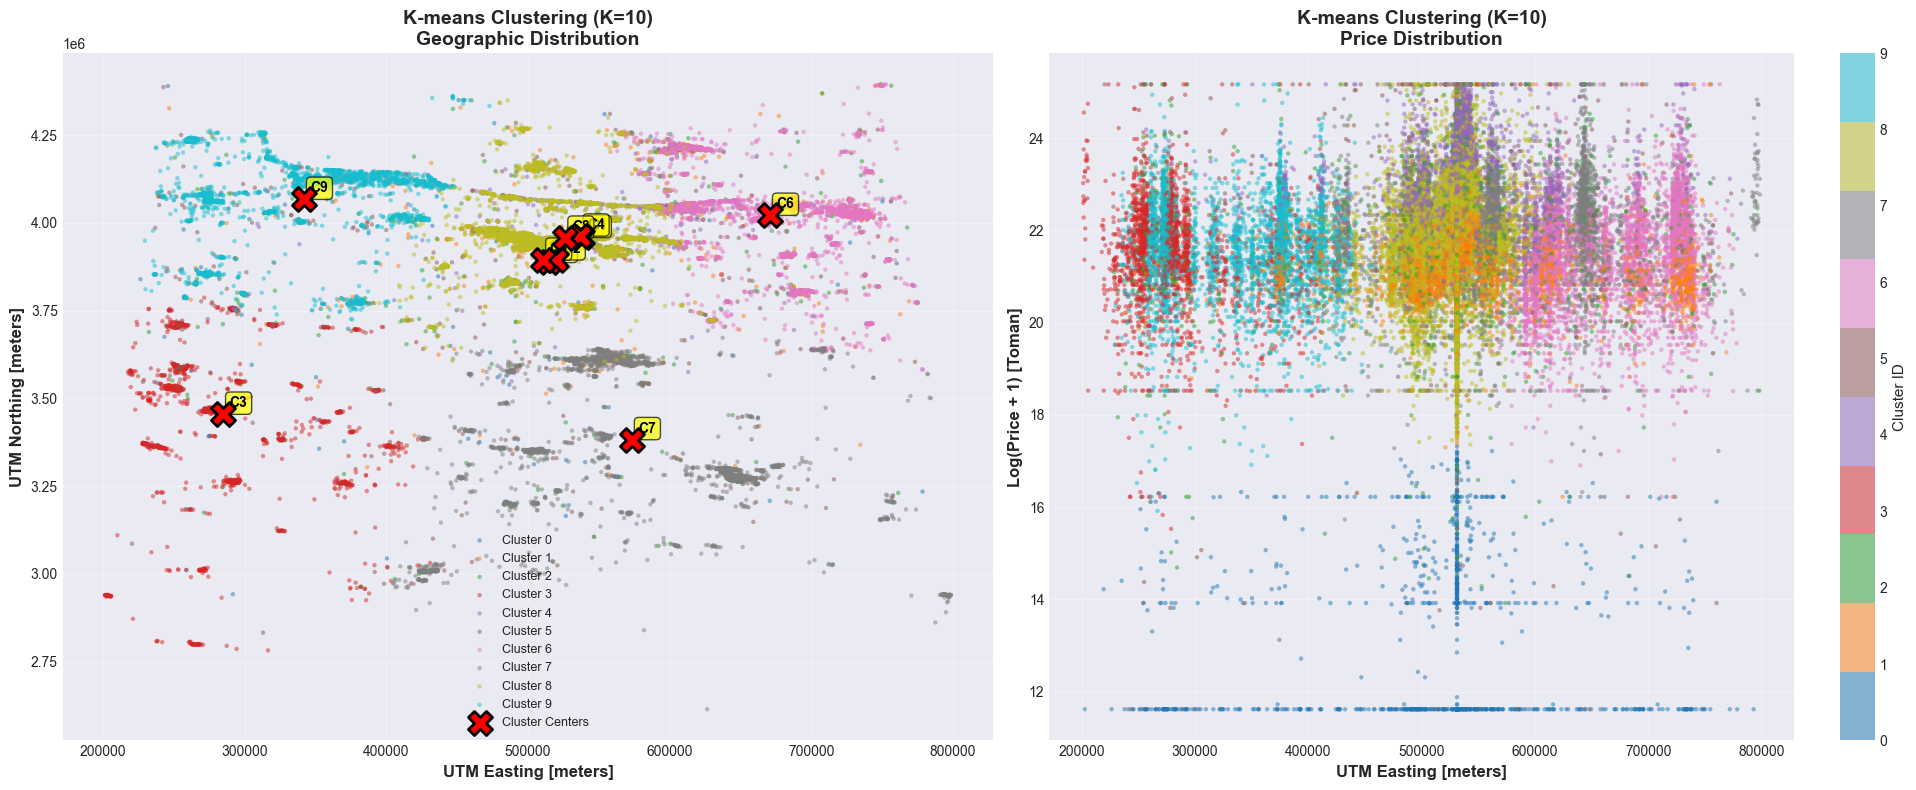


5. Saving results...
✓ Results saved to: simple_clustering_results_k10.csv

CLUSTERING SUMMARY

Cluster sizes:
  Cluster 0: 1122 properties (2.2%)
  Cluster 1: 7123 properties (14.2%)
  Cluster 2: 2546 properties (5.1%)
  Cluster 3: 1871 properties (3.7%)
  Cluster 4: 6570 properties (13.1%)
  Cluster 5: 863 properties (1.7%)
  Cluster 6: 4188 properties (8.4%)
  Cluster 7: 3308 properties (6.6%)
  Cluster 8: 19012 properties (38.0%)
  Cluster 9: 3397 properties (6.8%)

Price statistics by cluster:
                 mean        median           std
cluster                                          
0        2.788997e+06  1.111110e+05  5.050242e+06
1        2.628217e+09  1.820000e+09  4.901317e+09
2        7.508928e+09  3.500000e+09  1.266454e+10
3        3.877120e+09  2.200000e+09  7.768124e+09
4        1.487466e+10  8.400000e+09  1.753716e+10
5        1.613182e+10  3.800000e+09  2.637791e+10
6        3.470957e+09  2.200000e+09  5.774195e+09
7        5.423355e+09  3.200000e+09  9.346804

In [30]:
def simple_main_pipeline():
    """
    Simple and robust main pipeline
    """
    print("=" * 80)
    print("SIMPLE BUT EFFECTIVE REAL ESTATE CLUSTERING")
    print("=" * 80)
    
    try:
        # Step 1: Load data
        print("\n1. Loading data...")
        data = load_and_prepare_data(CLUSTERED_DATA_PATH)
        
        # Step 2: Create features (using safe version)
        print("\n2. Creating features...")
        X, features, data_sample = create_safe_features(data, sample_size=50000)
        
        print(f"\nFeature matrix summary:")
        print(f"  Shape: {X.shape}")
        print(f"  Features: {features}")
        print(f"  Sample data shape: {data_sample.shape}")
        
        # Step 3: Perform clustering
        print("\n3. Running K-means clustering...")
        kmeans_model, cluster_labels, scaler, pca, X_scaled = robust_kmeans_clustering(
            X, n_clusters=N_CLUSTERS
        )
        
        if kmeans_model is None:
            print("Clustering failed!")
            return None
        
        # Step 4: Create visualization
        print("\n4. Creating visualizations...")
        clustered_data, centers = create_simple_visualization(
            data_sample, cluster_labels, kmeans_model
        )
        
        if clustered_data is None:
            print("Visualization failed!")
            return None
        
        # Step 5: Save results
        print("\n5. Saving results...")
        
        # Create results dataframe
        results_df = pd.DataFrame({
            'cluster': cluster_labels,
            'utm_easting': data_sample['utm_easting'].values[:len(cluster_labels)],
            'utm_northing': data_sample['utm_northing'].values[:len(cluster_labels)]
        })
        
        # Add other columns if available
        if 'price_value' in data_sample.columns:
            results_df['price_value'] = data_sample['price_value'].values[:len(cluster_labels)]
            results_df['log_price'] = np.log1p(results_df['price_value'].clip(lower=0))
        
        if 'building_size' in data_sample.columns:
            results_df['building_size'] = data_sample['building_size'].values[:len(cluster_labels)]
        
        # Save to CSV
        results_file = f'simple_clustering_results_k{N_CLUSTERS}.csv'
        results_df.to_csv(results_file, index=False)
        print(f"✓ Results saved to: {results_file}")
        
        # Step 6: Display summary
        print("\n" + "=" * 80)
        print("CLUSTERING SUMMARY")
        print("=" * 80)
        
        cluster_stats = clustered_data.groupby('cluster').size()
        print(f"\nCluster sizes:")
        for cluster_id, size in cluster_stats.items():
            percentage = (size / len(clustered_data)) * 100
            print(f"  Cluster {cluster_id}: {size} properties ({percentage:.1f}%)")
        
        if 'price_value' in clustered_data.columns:
            price_stats = clustered_data.groupby('cluster')['price_value'].agg(['mean', 'median', 'std'])
            print(f"\nPrice statistics by cluster:")
            print(price_stats.round(2))
        
        print(f"\nTotal properties clustered: {len(clustered_data):,}")
        print(f"Number of clusters: {len(np.unique(cluster_labels))}")
        
        return {
            'kmeans_model': kmeans_model,
            'clustered_data': clustered_data,
            'cluster_labels': cluster_labels,
            'cluster_centers': centers
        }
        
    except Exception as e:
        print(f"\n❌ Error in pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# اجرای pipeline ساده
print("\nExecuting simple pipeline...")
results = simple_main_pipeline()

if results:
    print("\n✅ Simple pipeline completed successfully!")
else:
    print("\n❌ Pipeline failed!")

start Pipeline for find optimise K
📥 مرحله 1: بارگذاری و پاکسازی داده‌ها
✓ اندازه اولیه: (566444, 26)

📊 Missing values (>20%):
Series([], dtype: float64)
✓ حذف شد 0 ستون با missing >60%

📈 تعداد ستون‌های عددی: 18
✓ حذف ردیف‌های کاملاً خالی: (566444, 25)
✓ نمونه‌گیری Stratified: (49999, 25)

🔧 مرحله 2: ایجاد فیچرهای robust
  ✓ log_price: log-transformed, p1-p99 clipped
  ✓ building_size: clipped, NaN filled
  ✓ rooms_count: NaN filled with median
  ✓ property_type_encoded: NaN filled with median
  ✓ amenities_score: 5 features summed

✓ تعداد فیچرهای نهایی: 5
✓ تعداد نمونه‌های پاک: 49999
✓ فیچرهای استفاده‌شده: ['log_price', 'building_size', 'rooms_count', 'property_type_encoded', 'amenities_score']

📈 Statistics:
                            mean       std        min        max
log_price              21.635291  1.756172  11.618294  25.167475
building_size          -0.029948  0.006862  -0.032058   0.026926
rooms_count             0.127190  0.915388  -2.062631   3.425753
property_type_enc

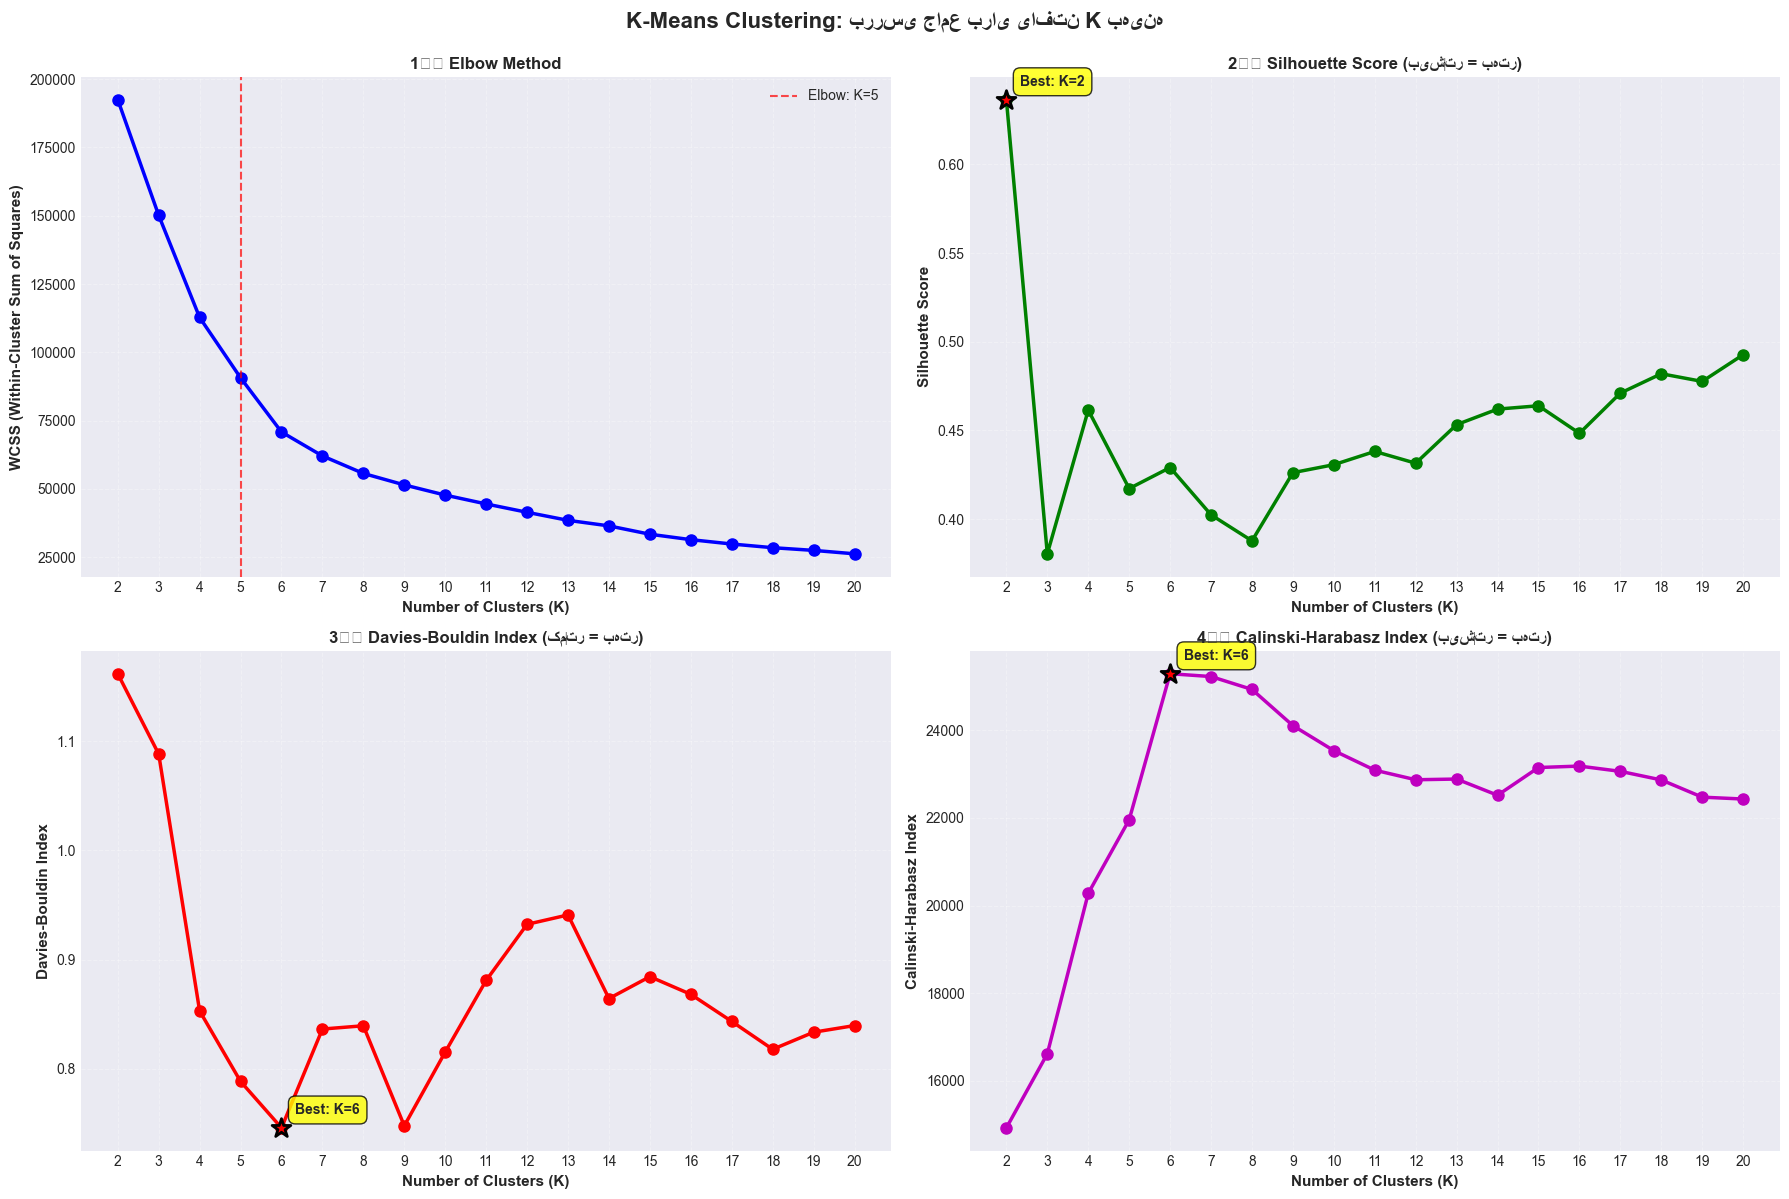


🎯 مرحله 6: توصیه نهایی برای K
✓ بهترین K برای Silhouette Score: 2
✓ بهترین K برای Davies-Bouldin Index: 6
✓ بهترین K برای Calinski-Harabasz Index: 6

🏆 K پیشنهادی (بر اساس رای بیشتری): 6
   رأی‌های دریافت‌شده: {2: 1, 6: 2}

💡 توصیه‌های حرفه‌ای:

1️⃣ روش Elbow (بررسی کاهش WCSS):
   K=3: کاهش تنها -22.00% (احتمال elbow point)

2️⃣ معایشه بین complexity و quality:
   Silhouette حول 2 به 0.636
   Davies-Bouldin حول 6 به 0.746

✓ result saved: optimal_k_analysis_results.csv

finaly. K prefered: 6


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_samples
)
import warnings
warnings.filterwarnings('ignore')

# تنظیمات
CLUSTERING_DATA_PATH = 'clustering_data.csv'
RANDOM_STATE = 42
K_RANGE = range(2, 21)  # K از 2 تا 20
SAMPLE_SIZE = 50000

# =====================================================================
# مرحله 1: داده‌سازی و پاکسازی داده‌ها (Data Preparation)
# =====================================================================

def load_and_clean_data(filepath, sample_size=SAMPLE_SIZE):
    """
    بارگذاری و پاکسازی داده‌ها با جزئیات کاملی
    """
    print("📥 مرحله 1: بارگذاری و پاکسازی داده‌ها")
    print("=" * 80)
    
    # بارگذاری
    data = pd.read_csv(filepath)
    print(f"✓ اندازه اولیه: {data.shape}")
    
    # حذف ستون‌های غیرضروری
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    
    # تحلیل missing values
    missing_pct = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
    print(f"\n📊 Missing values (>20%):")
    print(missing_pct[missing_pct > 20])
    
    # حذف ستون‌های با missing بیشتر از 60%
    cols_to_drop = missing_pct[missing_pct > 60].index.tolist()
    data = data.drop(columns=cols_to_drop)
    print(f"✓ حذف شد {len(cols_to_drop)} ستون با missing >60%")
    
    # تعیین ستون‌های عددی
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\n📈 تعداد ستون‌های عددی: {len(numeric_cols)}")
    
    # حذف ردیف‌های کاملاً خالی
    data = data.dropna(how='all')
    print(f"✓ حذف ردیف‌های کاملاً خالی: {data.shape}")
    
    # نمونه‌گیری stratified (اگر category وجود داشته باشد)
    if len(data) > sample_size:
        try:
            # Stratified sampling بر اساس category
            if 'cat2_slug' in data.columns:
                data = data.groupby('cat2_slug', group_keys=False).apply(
                    lambda x: x.sample(
                        n=min(len(x), max(1, int(sample_size * len(x) / len(data)))),
                        random_state=RANDOM_STATE
                    )
                ).reset_index(drop=True)
            else:
                data = data.sample(n=sample_size, random_state=RANDOM_STATE)
            print(f"✓ نمونه‌گیری Stratified: {data.shape}")
        except Exception as e:
            print(f"⚠️ نمونه‌گیری ساده: {str(e)}")
            data = data.sample(n=min(sample_size, len(data)), random_state=RANDOM_STATE)
    
    return data, numeric_cols

# =====================================================================
# مرحله 2: ایجاد فیچرهای مناسب و پاک
# =====================================================================

def create_robust_features(data, numeric_cols):
    """
    ایجاد فیچرهای مناسب با handle کردن outlier و missing values
    """
    print("\n🔧 مرحله 2: ایجاد فیچرهای robust")
    print("=" * 80)
    
    X = pd.DataFrame()
    features_created = []
    
    # =====================================================================
    # 1. فیچرهای جغرافیایی (Geographic)
    # =====================================================================
    if 'utm_easting' in numeric_cols and 'utm_northing' in numeric_cols:
        for col in ['utm_easting', 'utm_northing']:
            # IQR-based outlier detection
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Clip outliers
            cleaned = data[col].clip(lower_bound, upper_bound)
            
            # Fill remaining NaN with median
            cleaned = cleaned.fillna(cleaned.median())
            
            X[col] = cleaned
            features_created.append(col)
            print(f"  ✓ {col}: outliers clipped, NaN filled")
    
    # =====================================================================
    # 2. فیچرهای مالی (Price)
    # =====================================================================
    if 'price_value' in numeric_cols:
        price = data['price_value'].copy()
        
        # Remove extreme outliers (1% tails)
        p1 = price.quantile(0.01)
        p99 = price.quantile(0.99)
        price_clipped = price.clip(p1, p99)
        
        # Fill NaN
        price_clipped = price_clipped.fillna(price_clipped.median())
        
        # Log transformation (بهتر برای داده‌های skewed)
        X['log_price'] = np.log1p(price_clipped)
        features_created.append('log_price')
        print(f"  ✓ log_price: log-transformed, p1-p99 clipped")
    
    # =====================================================================
    # 3. فیچرهای فیزیکی (Building Size)
    # =====================================================================
    if 'building_size' in numeric_cols:
        size = data['building_size'].copy()
        
        # Clip outliers
        q1_size = size.quantile(0.01)
        q99_size = size.quantile(0.99)
        size_clipped = size.clip(q1_size, q99_size)
        
        # Fill NaN
        size_clipped = size_clipped.fillna(size_clipped.median())
        
        X['building_size'] = size_clipped
        features_created.append('building_size')
        print(f"  ✓ building_size: clipped, NaN filled")
    
    # =====================================================================
    # 4. فیچرهای دیگر
    # =====================================================================
    for col in ['rooms_count', 'property_type_encoded']:
        if col in numeric_cols:
            cleaned = data[col].copy()
            cleaned = cleaned.fillna(cleaned.median())
            X[col] = cleaned
            features_created.append(col)
            print(f"  ✓ {col}: NaN filled with median")
    
    # =====================================================================
    # 5. Amenities score
    # =====================================================================
    amenity_cols = [c for c in data.columns if c.startswith('has_')]
    if amenity_cols:
        amenities = 0
        for col in amenity_cols:
            if col in data.columns:
                # Convert to binary
                col_binary = data[col].map({
                    'true': 1, 'True': 1, True: 1,
                    'false': 0, 'False': 0, False: 0,
                    np.nan: 0, None: 0
                }).fillna(0)
                amenities += col_binary
        
        X['amenities_score'] = amenities
        features_created.append('amenities_score')
        print(f"  ✓ amenities_score: {len(amenity_cols)} features summed")
    
    # =====================================================================
    # تنظیفات نهایی
    # =====================================================================
    
    # حذف ردیف‌های با NaN
    X = X.dropna()
    print(f"\n✓ تعداد فیچرهای نهایی: {X.shape[1]}")
    print(f"✓ تعداد نمونه‌های پاک: {X.shape[0]}")
    print(f"✓ فیچرهای استفاده‌شده: {features_created}")
    
    # بررسی statistics
    print(f"\n📈 Statistics:")
    print(X.describe().T[['mean', 'std', 'min', 'max']])
    
    return X, features_created

# =====================================================================
# مرحله 3: نرمال‌سازی و تبدیل‌های مناسب
# =====================================================================

def normalize_and_prepare(X, features_list):
    """
    نرمال‌سازی و تهیه داده برای clustering
    """
    print("\n⚖️ مرحله 3: نرمال‌سازی داده‌ها")
    print("=" * 80)
    
    # StandardScaler (بهتر برای K-means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"✓ StandardScaler applied")
    print(f"  Mean: {X_scaled.mean(axis=0).round(6)}")
    print(f"  Std: {X_scaled.std(axis=0).round(4)}")
    
    # اختیاری: PCA برای کاهش ابعاد
    # فقط اگر features بیشتر از 10 باشند
    if X_scaled.shape[1] > 10:
        print(f"\n📉 PCA برای کاهش ابعاد (>10 features):")
        pca = PCA(n_components=0.95)  # 95% variance
        X_pca = pca.fit_transform(X_scaled)
        
        print(f"  Original dimensions: {X_scaled.shape[1]}")
        print(f"  Reduced dimensions: {X_pca.shape[1]}")
        print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
        print(f"  Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)}")
        
        return X_scaled, X_pca, scaler, pca
    else:
        print(f"✓ No PCA (only {X_scaled.shape[1]} features)")
        return X_scaled, X_scaled, scaler, None

# =====================================================================
# مرحله 4: یافتن K بهینه با روش‌های مختلف
# =====================================================================

def find_optimal_k_comprehensive(X, k_range=K_RANGE):
    """
    یافتن K بهینه با استفاده از 4 معیار مختلف
    
    معیارهای استفاده‌شده:
    1. Elbow Method (WCSS)
    2. Silhouette Score
    3. Davies-Bouldin Index
    4. Calinski-Harabasz Index
    """
    print("\n🎯 مرحله 4: یافتن K بهینه")
    print("=" * 80)
    
    results = {
        'k': [],
        'wcss': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': []
    }
    
    kmeans_models = {}  # برای ذخیره مدل‌ها
    
    for k in k_range:
        print(f"\n⏳ در حال اجرای K={k}...", end=" ")
        
        # ایجاد و آموزش مدل
        kmeans = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=50,  # بیشتر initializations برای stability
            max_iter=500,
            tol=1e-4,
            random_state=RANDOM_STATE,
            algorithm='elkan'
        )
        
        labels = kmeans.fit_predict(X)
        kmeans_models[k] = kmeans
        
        # 1. WCSS (Within-Cluster Sum of Squares)
        wcss = kmeans.inertia_
        
        # 2. Silhouette Score
        if k < len(X):  # Silhouette needs n > k
            sil_score = silhouette_score(X, labels)
        else:
            sil_score = -1
        
        # 3. Davies-Bouldin Index (کم‌تر = بهتر)
        if k > 1:
            db_index = davies_bouldin_score(X, labels)
        else:
            db_index = np.inf
        
        # 4. Calinski-Harabasz Index (بیش‌تر = بهتر)
        if k > 1 and k < len(X):
            ch_index = calinski_harabasz_score(X, labels)
        else:
            ch_index = 0
        
        # ذخیره نتایج
        results['k'].append(k)
        results['wcss'].append(wcss)
        results['silhouette'].append(sil_score)
        results['davies_bouldin'].append(db_index)
        results['calinski_harabasz'].append(ch_index)
        
        print(f"✓ WCSS={wcss:.2e}, Sil={sil_score:.3f}, DB={db_index:.3f}, CH={ch_index:.1f}")
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "=" * 80)
    print("📊 خلاصه نتایج:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    
    return results_df, kmeans_models

# =====================================================================
# مرحله 5: تصویر‌سازی جامع نتایج
# =====================================================================

def plot_optimal_k_analysis(results_df):
    """
    تصویر‌سازی تمام معیارها
    """
    print("\n📈 مرحله 5: تصویر‌سازی نتایج")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('K-Means Clustering: بررسی جامع برای یافتن K بهینه', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # =====================================================================
    # Plot 1: WCSS (Elbow Method)
    # =====================================================================
    ax1 = axes[0, 0]
    ax1.plot(results_df['k'], results_df['wcss'], 'bo-', linewidth=2.5, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
    ax1.set_title('1️⃣ Elbow Method', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xticks(results_df['k'])
    
    # تایید "elbow" point
    # محاسبه شیب تغییرات
    wcss_diff = np.diff(results_df['wcss'])
    wcss_diff2 = np.diff(wcss_diff)
    if len(wcss_diff2) > 0:
        elbow_idx = np.argmax(wcss_diff2) + 2  # +2 برای اصلاح offset
        if elbow_idx < len(results_df):
            elbow_k = results_df.iloc[elbow_idx]['k']
            ax1.axvline(x=elbow_k, color='r', linestyle='--', alpha=0.7, label=f'Elbow: K={int(elbow_k)}')
            ax1.legend()
    
    # =====================================================================
    # Plot 2: Silhouette Score
    # =====================================================================
    ax2 = axes[0, 1]
    ax2.plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2.5, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
    ax2.set_title('2️⃣ Silhouette Score (بیش‌تر = بهتر)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xticks(results_df['k'])
    
    # بهترین silhouette
    best_sil_idx = results_df['silhouette'].idxmax()
    best_sil_k = results_df.loc[best_sil_idx, 'k']
    ax2.scatter([best_sil_k], [results_df.loc[best_sil_idx, 'silhouette']], 
               color='red', s=200, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax2.annotate(f'Best: K={int(best_sil_k)}', 
                xy=(best_sil_k, results_df.loc[best_sil_idx, 'silhouette']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                fontsize=10, fontweight='bold')
    
    # =====================================================================
    # Plot 3: Davies-Bouldin Index
    # =====================================================================
    ax3 = axes[1, 0]
    # فیلتر کردن inf values
    db_values = results_df['davies_bouldin'].copy()
    db_values = db_values.replace([np.inf, -np.inf], np.nan)
    
    ax3.plot(results_df['k'], db_values, 'ro-', linewidth=2.5, markersize=8)
    ax3.set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
    ax3.set_title('3️⃣ Davies-Bouldin Index (کم‌تر = بهتر)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xticks(results_df['k'])
    
    # بهترین DB
    best_db_idx = db_values.idxmin()
    if not np.isnan(best_db_idx):
        best_db_k = results_df.loc[best_db_idx, 'k']
        ax3.scatter([best_db_k], [db_values.loc[best_db_idx]], 
                   color='red', s=200, marker='*', edgecolors='black', linewidths=2, zorder=5)
        ax3.annotate(f'Best: K={int(best_db_k)}', 
                    xy=(best_db_k, db_values.loc[best_db_idx]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                    fontsize=10, fontweight='bold')
    
    # =====================================================================
    # Plot 4: Calinski-Harabasz Index
    # =====================================================================
    ax4 = axes[1, 1]
    ax4.plot(results_df['k'], results_df['calinski_harabasz'], 'mo-', linewidth=2.5, markersize=8)
    ax4.set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Calinski-Harabasz Index', fontsize=11, fontweight='bold')
    ax4.set_title('4️⃣ Calinski-Harabasz Index (بیش‌تر = بهتر)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_xticks(results_df['k'])
    
    # بهترین CH
    best_ch_idx = results_df['calinski_harabasz'].idxmax()
    best_ch_k = results_df.loc[best_ch_idx, 'k']
    ax4.scatter([best_ch_k], [results_df.loc[best_ch_idx, 'calinski_harabasz']], 
               color='red', s=200, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax4.annotate(f'Best: K={int(best_ch_k)}', 
                xy=(best_ch_k, results_df.loc[best_ch_idx, 'calinski_harabasz']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('optimal_k_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ نمودار ذخیره شد: optimal_k_comprehensive_analysis.png")
    plt.show()

# =====================================================================
# مرحله 6: توصیه نهایی
# =====================================================================

def recommend_optimal_k(results_df):
    """
    بر اساس تمام معیارها، K بهینه را توصیه کن
    """
    print("\n🎯 مرحله 6: توصیه نهایی برای K")
    print("=" * 80)
    
    # بهترین K برای هر معیار
    best_silhouette_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
    best_db_k = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
    best_ch_k = results_df.loc[results_df['calinski_harabasz'].idxmax(), 'k']
    
    print(f"✓ بهترین K برای Silhouette Score: {int(best_silhouette_k)}")
    print(f"✓ بهترین K برای Davies-Bouldin Index: {int(best_db_k)}")
    print(f"✓ بهترین K برای Calinski-Harabasz Index: {int(best_ch_k)}")
    
    # Ensemble recommendation
    recommended_ks = [best_silhouette_k, best_db_k, best_ch_k]
    recommended_ks = [k for k in recommended_ks if k != np.inf and not np.isnan(k)]
    
    # بیشترین رای
    from collections import Counter
    vote_count = Counter([int(k) for k in recommended_ks])
    most_common_k = vote_count.most_common(1)[0][0]
    
    print(f"\n🏆 K پیشنهادی (بر اساس رای بیشتری): {most_common_k}")
    print(f"   رأی‌های دریافت‌شده: {dict(vote_count)}")
    
    # توصیه‌های اضافی
    print(f"\n💡 توصیه‌های حرفه‌ای:")
    
    # 1. بررسی Elbow
    wcss_diff = np.diff(results_df['wcss'])
    wcss_pct_decrease = (wcss_diff / results_df['wcss'].iloc[:-1].values) * 100
    
    print(f"\n1️⃣ روش Elbow (بررسی کاهش WCSS):")
    for i, (k, pct) in enumerate(zip(results_df['k'].iloc[1:], wcss_pct_decrease)):
        if pct < 5:  # کاهش کمتر از 5%
            print(f"   K={int(k)}: کاهش تنها {pct:.2f}% (احتمال elbow point)")
            break
        print(f"   K={int(k)}: کاهش {pct:.2f}%")
    
    # 2. بررسی تعادل
    print(f"\n2️⃣ معایشه بین complexity و quality:")
    print(f"   Silhouette حول {best_silhouette_k:.0f} به {results_df['silhouette'].max():.3f}")
    print(f"   Davies-Bouldin حول {best_db_k:.0f} به {results_df['davies_bouldin'].min():.3f}")
    
    return int(most_common_k)

# =====================================================================
# pipeline execute
# =====================================================================

def main_optimal_k_pipeline():
    """
    Pipeline کامل برای یافتن K بهینه
    """
    print("start Pipeline for find optimise K")
    print("=" * 80)
    
    # Step 1: Load and clean
    data, numeric_cols = load_and_clean_data(CLUSTERING_DATA_PATH)
    
    # Step 2: Create features
    X, features_list = create_robust_features(data, numeric_cols)
    
    # Step 3: Normalize
    X_scaled, X_prepared, scaler, pca = normalize_and_prepare(X, features_list)
    
    # Step 4: Find optimal K
    results_df, kmeans_models = find_optimal_k_comprehensive(X_prepared)
    
    # Step 5: Visualize
    plot_optimal_k_analysis(results_df)
    
    # Step 6: Recommend
    recommended_k = recommend_optimal_k(results_df)
    
    # Save results
    results_df.to_csv('optimal_k_analysis_results.csv', index=False)
    print(f"\n✓ result saved: optimal_k_analysis_results.csv")
    
    return {
        'results_df': results_df,
        'recommended_k': recommended_k,
        'kmeans_models': kmeans_models,
        'X_scaled': X_scaled,
        'X_prepared': X_prepared,
        'scaler': scaler,
        'pca': pca,
        'data': data,
        'features': features_list
    }

# اجرای برنامه
if __name__ == "__main__":
    results = main_optimal_k_pipeline()
    print(f"\nfinaly. K prefered: {results['recommended_k']}")


DBSCAN CLUSTERING PIPELINE FOR REAL ESTATE DATA
Loading and converting data to UTM...
Original data shape: (566444, 25)
Available columns: ['cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

Converting latitude/longitude to UTM...
Successfully converted 566444/566444 points to UTM
UTM zones: {'39S': 455876, '40S': 34709, '38S': 31392, '39R': 28754, '40R': 12192, '41R': 3209, '41S': 284, '38R': 20, '40Q': 4, '39Q': 2, '37S': 1, '38T': 1}
Sampled 50000 rows from dataset

Final data shape: (50000, 28)

Data statistics:
         utm_easting  utm_northing   price_value
count   50000.000000  5.0000

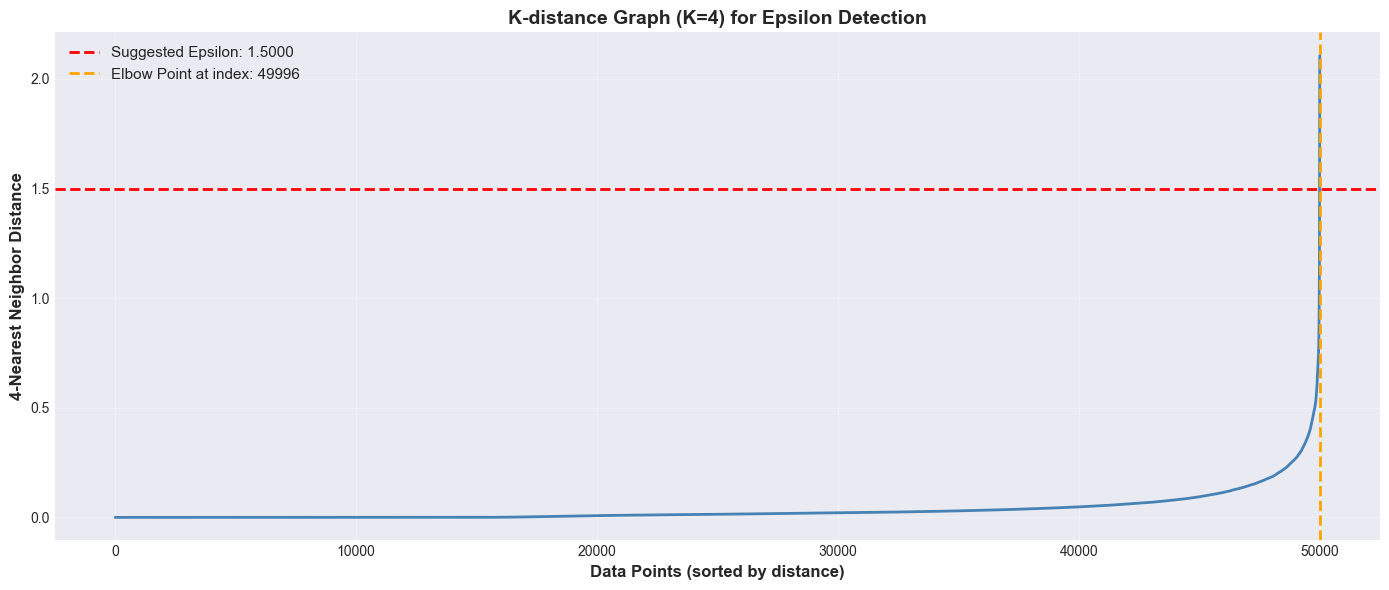


Optimal epsilon (from elbow detection): 1.5000
Distance statistics:
  Min: 0.0000
  Max: 2.1071
  Mean: 0.0370
  Std: 0.0761

Performing grid search for optimal DBSCAN parameters...

Error occurred: bad allocation


Traceback (most recent call last):
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\352523698.py", line 663, in main_dbscan_pipeline
    optimal_eps, optimal_min_samples, results_df = grid_search_dbscan_parameters(
                                                   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X_scaled, eps_range=eps_range, min_samples_range=min_samples_range
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\352523698.py", line 234, in grid_search_dbscan_parameters
    labels, n_clusters, n_noise, silhouette = perform_dbscan_with_parameters(
                                              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X_scaled, eps, min_samples
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\Manoocher\AppData\Local\Temp\ipykernel_28340\352523698.py", line 201, in perform_dbscan_with_parameters
    labels = dbscan.fit_predict(X_scaled)
  File 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import utm
from functools import lru_cache
import warnings
warnings.filterwarnings('ignore')

CLUSTERING_DATA_PATH = 'clustering_data.csv'
RANDOM_STATE = 42

# =====================================================================
# Step 0: UTM Conversion Helper
# =====================================================================

@lru_cache(maxsize=10000)
def convert_latlon_to_utm(lat, lon):
    """
    Convert latitude/longitude to UTM coordinates
    """
    try:
        easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
        return easting, northing, zone_number, zone_letter
    except Exception as e:
        return np.nan, np.nan, np.nan, np.nan

def load_and_convert_utm_data(file_path, sample_size=50000):
    """
    Load data and convert lat/lon to UTM coordinates
    """
    print("Loading and converting data to UTM...")
    print("=" * 80)
    
    data = pd.read_csv(file_path)
    
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    
    print(f"Original data shape: {data.shape}")
    print(f"Available columns: {list(data.columns)}")
    
    # Convert lat/lon to UTM if available
    if 'location_latitude' in data.columns and 'location_longitude' in data.columns:
        print("\nConverting latitude/longitude to UTM...")
        
        utm_data = []
        for idx, row in data.iterrows():
            if pd.notna(row['location_latitude']) and pd.notna(row['location_longitude']):
                easting, northing, zone_num, zone_letter = convert_latlon_to_utm(
                    row['location_latitude'],
                    row['location_longitude']
                )
                utm_data.append((easting, northing, zone_num, zone_letter))
            else:
                utm_data.append((np.nan, np.nan, np.nan, np.nan))
        
        data['utm_easting'] = [x[0] for x in utm_data]
        data['utm_northing'] = [x[1] for x in utm_data]
        data['utm_zone'] = [f"{int(x[2])}{x[3]}" if not np.isnan(x[2]) else np.nan for x in utm_data]
        
        initial_count = len(data)
        data = data.dropna(subset=['utm_easting', 'utm_northing'])
        final_count = len(data)
        
        print(f"Successfully converted {final_count}/{initial_count} points to UTM")
        print(f"UTM zones: {data['utm_zone'].value_counts().to_dict()}")
    
    # Handle missing price values
    if 'price_value' in data.columns:
        data['price_value'] = data['price_value'].fillna(data['price_value'].median())
    
    # Sample data if too large
    if len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=RANDOM_STATE)
        print(f"Sampled {len(data)} rows from dataset")
    
    print(f"\nFinal data shape: {data.shape}")
    print(f"\nData statistics:")
    print(data[['utm_easting', 'utm_northing', 'price_value']].describe())
    
    return data

# =====================================================================
# Step 1: Prepare Features for DBSCAN
# =====================================================================

def prepare_features_for_dbscan(data):
    """
    Prepare UTM and price features with proper scaling
    """
    print("\nPreparing features for DBSCAN...")
    print("=" * 80)
    
    X = pd.DataFrame()
    
    # Extract and prepare UTM coordinates
    X['utm_easting'] = data['utm_easting'].copy()
    X['utm_northing'] = data['utm_northing'].copy()
    
    # Handle price feature with log transformation
    if 'price_value' in data.columns:
        price = data['price_value'].copy()
        
        # Clip extreme outliers
        p1 = price.quantile(0.01)
        p99 = price.quantile(0.99)
        price_clipped = price.clip(p1, p99)
        
        # Log transformation
        price_transformed = np.log1p(price_clipped)
        X['log_price'] = price_transformed
        
        print(f"Price statistics (original):")
        print(f"  Min: {price.min():,.0f}, Max: {price.max():,.0f}")
        print(f"  Mean: {price.mean():,.0f}, Std: {price.std():,.0f}")
        
        print(f"\nPrice statistics (log-transformed):")
        print(f"  Min: {price_transformed.min():.2f}, Max: {price_transformed.max():.2f}")
        print(f"  Mean: {price_transformed.mean():.2f}, Std: {price_transformed.std():.2f}")
    
    # Standardize all features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"\nScaled features shape: {X_scaled.shape}")
    print(f"Scaled mean (should be ~0): {X_scaled.mean(axis=0)}")
    print(f"Scaled std (should be ~1): {X_scaled.std(axis=0)}")
    
    return X, X_scaled, scaler

# =====================================================================
# Step 2: Find Optimal Epsilon Using K-distance Graph
# =====================================================================

def find_optimal_epsilon(X_scaled, k=4):
    """
    Find optimal epsilon using k-distance graph
    """
    print("\nFinding optimal epsilon using k-distance graph...")
    print("=" * 80)
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Plot k-distance graph
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(distances, linewidth=2, color='steelblue')
    ax.set_xlabel('Data Points (sorted by distance)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{k}-Nearest Neighbor Distance', fontsize=12, fontweight='bold')
    ax.set_title(f'K-distance Graph (K={k}) for Epsilon Detection', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Find elbow point using second derivative
    second_derivative = np.diff(distances, n=2)
    elbow_idx = np.argmax(second_derivative)
    optimal_eps = distances[elbow_idx]
    
    ax.axhline(y=optimal_eps, color='red', linestyle='--', 
               linewidth=2, label=f'Suggested Epsilon: {optimal_eps:.4f}')
    ax.axvline(x=elbow_idx, color='orange', linestyle='--', 
               linewidth=2, label=f'Elbow Point at index: {elbow_idx}')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.savefig('k_distance_graph_dbscan.png', dpi=300, bbox_inches='tight')
    print(f"K-distance graph saved as: k_distance_graph_dbscan.png")
    plt.show()
    
    print(f"\nOptimal epsilon (from elbow detection): {optimal_eps:.4f}")
    print(f"Distance statistics:")
    print(f"  Min: {distances.min():.4f}")
    print(f"  Max: {distances.max():.4f}")
    print(f"  Mean: {distances.mean():.4f}")
    print(f"  Std: {distances.std():.4f}")
    
    return optimal_eps, distances

# =====================================================================
# Step 3: Grid Search for Optimal Parameters
# =====================================================================

def perform_dbscan_with_parameters(X_scaled, eps, min_samples):
    """
    Perform DBSCAN with given parameters
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters > 1 and n_noise < len(labels) - 1:
        mask = labels != -1
        if mask.sum() > 0:
            silhouette = silhouette_score(X_scaled[mask], labels[mask])
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    return labels, n_clusters, n_noise, silhouette

def grid_search_dbscan_parameters(X_scaled, eps_range=None, min_samples_range=None):
    """
    Grid search for optimal DBSCAN parameters targeting 3 clusters
    """
    print("\nPerforming grid search for optimal DBSCAN parameters...")
    print("=" * 80)
    
    if eps_range is None:
        eps_range = np.arange(0.1, 1.0, 0.1)
    
    if min_samples_range is None:
        min_samples_range = [3, 5, 10, 15, 20]
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            labels, n_clusters, n_noise, silhouette = perform_dbscan_with_parameters(
                X_scaled, eps, min_samples
            )
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_pct': (n_noise / len(labels)) * 100,
                'silhouette': silhouette
            })
    
    results_df = pd.DataFrame(results)
    
    # Target 3 clusters
    target_results = results_df[results_df['n_clusters'] == 3]
    
    if len(target_results) > 0:
        print(f"\nFound {len(target_results)} parameter combinations with 3 clusters")
        
        best_idx = target_results.loc[
            (target_results['noise_pct'] < 30) & (target_results['silhouette'] > -0.5)
        ].sort_values('silhouette', ascending=False).index
        
        if len(best_idx) > 0:
            best_params = target_results.loc[best_idx[0]]
        else:
            best_params = target_results.iloc[0]
    else:
        print(f"\nNo exact 3-cluster solution found")
        print(f"Available cluster counts: {sorted(results_df['n_clusters'].unique())}")
        
        results_df['cluster_distance_to_3'] = abs(results_df['n_clusters'] - 3)
        best_params = results_df.loc[
            results_df['cluster_distance_to_3'].idxmin()
        ]
    
    print(f"\nOptimal parameters selected:")
    print(f"  eps: {best_params['eps']:.4f}")
    print(f"  min_samples: {int(best_params['min_samples'])}")
    print(f"  Resulting clusters: {int(best_params['n_clusters'])}")
    print(f"  Noise points: {int(best_params['n_noise'])} ({best_params['noise_pct']:.2f}%)")
    print(f"  Silhouette score: {best_params['silhouette']:.4f}")
    
    return float(best_params['eps']), int(best_params['min_samples']), results_df

# =====================================================================
# Step 4: Final DBSCAN Clustering
# =====================================================================

def final_dbscan_clustering(X_scaled, eps, min_samples):
    """
    Perform final DBSCAN clustering with optimal parameters
    """
    print("\nPerforming final DBSCAN clustering...")
    print("=" * 80)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"\nClustering Results:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Number of noise points: {n_noise}")
    print(f"  Noise percentage: {(n_noise/len(cluster_labels))*100:.2f}%")
    
    unique_labels = set(cluster_labels)
    print(f"\nCluster distribution:")
    for label in sorted(unique_labels):
        count = list(cluster_labels).count(label)
        pct = (count / len(cluster_labels)) * 100
        if label == -1:
            print(f"  Noise: {count} points ({pct:.2f}%)")
        else:
            print(f"  Cluster {label}: {count} points ({pct:.2f}%)")
    
    # Calculate metrics (only for non-noise points)
    if n_clusters > 1:
        mask = cluster_labels != -1
        if mask.sum() > n_clusters:
            silhouette = silhouette_score(X_scaled[mask], cluster_labels[mask])
            davies_bouldin = davies_bouldin_score(X_scaled[mask], cluster_labels[mask])
            calinski_harabasz = calinski_harabasz_score(X_scaled[mask], cluster_labels[mask])
        else:
            silhouette = -1
            davies_bouldin = -1
            calinski_harabasz = -1
    else:
        silhouette = -1
        davies_bouldin = -1
        calinski_harabasz = -1
    
    print(f"\nEvaluation Metrics:")
    print(f"  Silhouette Score: {silhouette:.4f} (range: -1 to 1, higher is better)")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.4f} (higher is better)")
    
    return dbscan, cluster_labels, n_clusters, n_noise

# =====================================================================
# Step 5: Visualization
# =====================================================================

def plot_dbscan_results(data, cluster_labels, eps, min_samples):
    """
    Create comprehensive DBSCAN visualization
    """
    print("\nCreating DBSCAN visualization...")
    print("=" * 80)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    unique_labels = set(cluster_labels)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    colors = plt.cm.tab10(np.linspace(0, 1, max(n_clusters + 1, 2)))
    
    # =====================================================================
    # Plot 1: UTM Easting vs Log Price
    # =====================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    for label in sorted(unique_labels):
        idx = np.where(cluster_labels == label)[0]
        
        if label == -1:
            ax1.scatter(
                data.iloc[idx, 0],
                np.log1p(data.iloc[idx, 2]),
                c='gray',
                marker='x',
                s=100,
                alpha=0.5,
                label='Noise',
                edgecolors='red',
                linewidths=1
            )
        else:
            ax1.scatter(
                data.iloc[idx, 0],
                np.log1p(data.iloc[idx, 2]),
                c=[colors[label % len(colors)]],
                marker='o',
                s=50,
                alpha=0.7,
                label=f'Cluster {label}',
                edgecolors='black',
                linewidths=0.5
            )
    
    ax1.set_xlabel('UTM Easting (meters)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Log(Price + 1) [Toman]', fontsize=12, fontweight='bold')
    ax1.set_title(f'DBSCAN: UTM Easting vs Price\n(eps={eps:.4f}, min_samples={min_samples})',
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # =====================================================================
    # Plot 2: UTM Northing vs Log Price
    # =====================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    for label in sorted(unique_labels):
        idx = np.where(cluster_labels == label)[0]
        
        if label == -1:
            ax2.scatter(
                data.iloc[idx, 1],
                np.log1p(data.iloc[idx, 2]),
                c='gray',
                marker='x',
                s=100,
                alpha=0.5,
                label='Noise',
                edgecolors='red',
                linewidths=1
            )
        else:
            ax2.scatter(
                data.iloc[idx, 1],
                np.log1p(data.iloc[idx, 2]),
                c=[colors[label % len(colors)]],
                marker='o',
                s=50,
                alpha=0.7,
                label=f'Cluster {label}',
                edgecolors='black',
                linewidths=0.5
            )
    
    ax2.set_xlabel('UTM Northing (meters)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Log(Price + 1) [Toman]', fontsize=12, fontweight='bold')
    ax2.set_title(f'DBSCAN: UTM Northing vs Price\n(eps={eps:.4f}, min_samples={min_samples})',
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # =====================================================================
    # Plot 3: Geographic Distribution (UTM Easting vs Northing)
    # =====================================================================
    ax3 = fig.add_subplot(gs[1, 0])
    
    for label in sorted(unique_labels):
        idx = np.where(cluster_labels == label)[0]
        
        if label == -1:
            ax3.scatter(
                data.iloc[idx, 0],
                data.iloc[idx, 1],
                c='gray',
                marker='x',
                s=100,
                alpha=0.5,
                label='Noise',
                edgecolors='red',
                linewidths=1
            )
        else:
            ax3.scatter(
                data.iloc[idx, 0],
                data.iloc[idx, 1],
                c=[colors[label % len(colors)]],
                marker='o',
                s=50,
                alpha=0.7,
                label=f'Cluster {label}',
                edgecolors='black',
                linewidths=0.5
            )
    
    ax3.set_xlabel('UTM Easting (meters)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('UTM Northing (meters)', fontsize=12, fontweight='bold')
    ax3.set_title(f'DBSCAN: Geographic Distribution\n(eps={eps:.4f}, min_samples={min_samples})',
                  fontsize=13, fontweight='bold')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # =====================================================================
    # Plot 4: Cluster Size Distribution
    # =====================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    
    cluster_sizes = []
    cluster_labels_list = []
    
    for label in sorted(unique_labels):
        size = list(cluster_labels).count(label)
        cluster_labels_list.append(f'Cluster {label}' if label != -1 else 'Noise')
        cluster_sizes.append(size)
    
    bars = ax4.bar(range(len(cluster_labels_list)), cluster_sizes,
                   color=colors[:len(cluster_labels_list)],
                   edgecolor='black', linewidth=1.5, alpha=0.7)
    
    for bar, size in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(size)}\n({100*size/len(cluster_labels):.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax4.set_xticks(range(len(cluster_labels_list)))
    ax4.set_xticklabels(cluster_labels_list, fontsize=11)
    ax4.set_ylabel('Number of Points', fontsize=12, fontweight='bold')
    ax4.set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle('DBSCAN Clustering: Real Estate Data (UTM + Price)',
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig('dbscan_clustering_results.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as: dbscan_clustering_results.png")
    plt.show()

# =====================================================================
# Step 6: Parameter Impact Analysis
# =====================================================================

def analyze_parameter_impact(results_df):
    """
    Analyze how parameters affect DBSCAN output
    """
    print("\nAnalyzing parameter impact on DBSCAN results...")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: eps vs number of clusters
    ax1 = axes[0, 0]
    for min_samp in sorted(results_df['min_samples'].unique()):
        subset = results_df[results_df['min_samples'] == min_samp]
        ax1.plot(subset['eps'], subset['n_clusters'], marker='o',
                label=f'min_samples={int(min_samp)}', linewidth=2)
    
    ax1.axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_xlabel('Epsilon (eps)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
    ax1.set_title('Impact of Epsilon on Cluster Count', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: eps vs noise percentage
    ax2 = axes[0, 1]
    for min_samp in sorted(results_df['min_samples'].unique()):
        subset = results_df[results_df['min_samples'] == min_samp]
        ax2.plot(subset['eps'], subset['noise_pct'], marker='s',
                label=f'min_samples={int(min_samp)}', linewidth=2)
    
    ax2.set_xlabel('Epsilon (eps)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Noise Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Impact of Epsilon on Noise Points', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: min_samples vs number of clusters
    ax3 = axes[1, 0]
    for eps in sorted(results_df['eps'].unique()):
        subset = results_df[results_df['eps'] == eps]
        ax3.plot(subset['min_samples'], subset['n_clusters'], marker='D',
                label=f'eps={eps:.2f}', linewidth=2)
    
    ax3.axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax3.set_xlabel('Min Samples', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
    ax3.set_title('Impact of Min Samples on Cluster Count', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Heatmap
    ax4 = axes[1, 1]
    pivot_data = results_df.pivot_table(values='n_clusters',
                                        index='min_samples',
                                        columns='eps',
                                        aggfunc='first')
    
    im = ax4.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto')
    ax4.set_xticks(range(len(pivot_data.columns)))
    ax4.set_yticks(range(len(pivot_data.index)))
    ax4.set_xticklabels([f'{x:.2f}' for x in pivot_data.columns], rotation=45)
    ax4.set_yticklabels([int(y) for y in pivot_data.index])
    ax4.set_xlabel('Epsilon (eps)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Min Samples', fontsize=12, fontweight='bold')
    ax4.set_title('Heatmap: Number of Clusters', fontsize=13, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Number of Clusters', fontsize=11)
    
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            ax4.text(j, i, int(pivot_data.values[i, j]),
                    ha="center", va="center", color="black", fontweight='bold')
    
    fig.suptitle('DBSCAN Parameter Impact Analysis',
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dbscan_parameter_impact.png', dpi=300, bbox_inches='tight')
    print("Parameter impact analysis saved as: dbscan_parameter_impact.png")
    plt.show()

# =====================================================================
# Step 7: Save Results
# =====================================================================

def save_clustering_results(data, cluster_labels, output_file='dbscan_results.csv'):
    """
    Save clustering results to CSV file
    """
    print("\nSaving clustering results...")
    print("=" * 80)
    
    results_df = pd.DataFrame({
        'utm_easting': data['utm_easting'].values,
        'utm_northing': data['utm_northing'].values,
        'price_value': data['price_value'].values,
        'log_price': np.log1p(data['price_value'].values),
        'cluster': cluster_labels
    })
    
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    
    print("\nCluster Statistics:")
    for cluster_id in sorted(results_df['cluster'].unique()):
        cluster_data = results_df[results_df['cluster'] == cluster_id]
        
        if cluster_id == -1:
            print(f"\nNoise Points: {len(cluster_data)} points ({100*len(cluster_data)/len(results_df):.2f}%)")
        else:
            print(f"\nCluster {cluster_id}:")
            print(f"  Count: {len(cluster_data)} ({100*len(cluster_data)/len(results_df):.2f}%)")
            print(f"  Price Mean: {cluster_data['price_value'].mean():,.0f}")
            print(f"  Price Median: {cluster_data['price_value'].median():,.0f}")
            print(f"  Price Std: {cluster_data['price_value'].std():,.0f}")
            print(f"  UTM Easting Range: {cluster_data['utm_easting'].min():,.0f} - {cluster_data['utm_easting'].max():,.0f}")
            print(f"  UTM Northing Range: {cluster_data['utm_northing'].min():,.0f} - {cluster_data['utm_northing'].max():,.0f}")
    
    return results_df

# =====================================================================
# Main Pipeline
# =====================================================================

def main_dbscan_pipeline():
    """
    Complete DBSCAN clustering pipeline
    """
    print("\n" + "=" * 80)
    print("DBSCAN CLUSTERING PIPELINE FOR REAL ESTATE DATA")
    print("=" * 80)
    
    try:
        # Step 1: Load and convert data
        data = load_and_convert_utm_data(CLUSTERING_DATA_PATH, sample_size=50000)
        
        # Step 2: Prepare features
        X_original, X_scaled, scaler = prepare_features_for_dbscan(data)
        
        # Step 3: Find optimal epsilon
        optimal_eps, distances = find_optimal_epsilon(X_scaled, k=4)
        
        # Step 4: Grid search for parameters
        eps_range = np.arange(optimal_eps * 0.5, optimal_eps * 2.0, optimal_eps * 0.2)
        min_samples_range = [3, 5, 10, 15, 20]
        
        optimal_eps, optimal_min_samples, results_df = grid_search_dbscan_parameters(
            X_scaled, eps_range=eps_range, min_samples_range=min_samples_range
        )
        
        # Step 5: Final clustering
        dbscan_model, cluster_labels, n_clusters, n_noise = final_dbscan_clustering(
            X_scaled, optimal_eps, optimal_min_samples
        )
        
        # Step 6: Visualize results
        plot_dbscan_results(data, cluster_labels, optimal_eps, optimal_min_samples)
        
        # Step 7: Analyze parameter impact
        analyze_parameter_impact(results_df)
        
        # Step 8: Save results
        final_results = save_clustering_results(data, cluster_labels)
        
        print("\n" + "=" * 80)
        print("DBSCAN PIPELINE COMPLETED SUCCESSFULLY")
        print("=" * 80)
        
        return {
            'data': data,
            'X_original': X_original,
            'X_scaled': X_scaled,
            'scaler': scaler,
            'dbscan_model': dbscan_model,
            'cluster_labels': cluster_labels,
            'results_df': final_results,
            'optimal_eps': optimal_eps,
            'optimal_min_samples': optimal_min_samples,
            'parameter_search_results': results_df
        }
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Execute the pipeline
if __name__ == "__main__":
    clustering_results = main_dbscan_pipeline()
    
    if clustering_results:
        print(f"\nOptimal Parameters Used:")
        print(f"  eps: {clustering_results['optimal_eps']:.4f}")
        print(f"  min_samples: {clustering_results['optimal_min_samples']}")


DBSCAN CLUSTERING PIPELINE FOR REAL ESTATE DATA

Step 1: Loading data...
Loading and converting data to UTM...
Original data shape: (566444, 25)
Available columns: ['cat2_slug', 'price_mode', 'price_value', 'building_size', 'rooms_count', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_restroom', 'floor_material', 'location_latitude', 'location_longitude', 'city_freq_encoded', 'size_category', 'rooms_category', 'amenities_count', 'property_type_encoded', 'cat3_slug_freq', 'city_slug_freq', 'neighborhood_slug_freq', 'created_at_month_freq', 'floor_freq']

Converting latitude/longitude to UTM...
Successfully converted 566444/566444 points to UTM
UTM zones: {'39S': 455876, '40S': 34709, '38S': 31392, '39R': 28754, '40R': 12192, '41R': 3209, '41S': 284, '38R': 20, '40Q': 4, '39Q': 2, '37S': 1, '38T': 1}
Sampled 50000 rows from dataset

Final data shape: (50000, 28)

Data statistics:
         utm_easting  utm_northing   price_value
cou

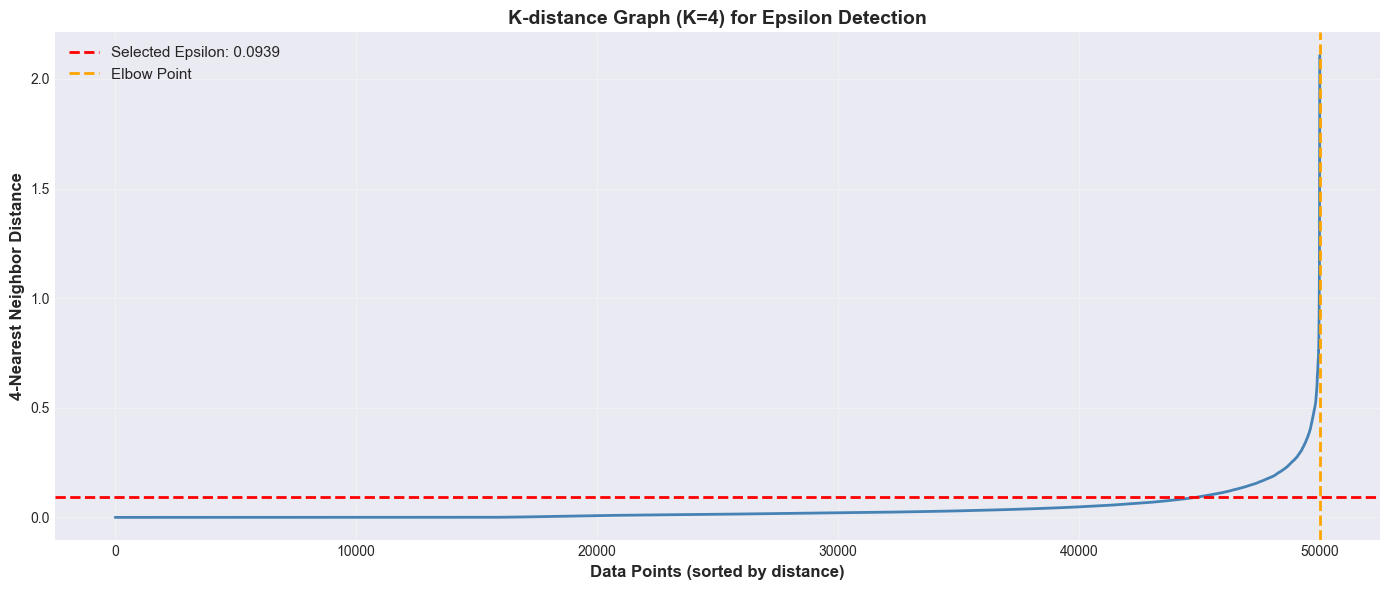


Epsilon Detection Results:
  Raw epsilon (from elbow): 1.5000
  Constrained epsilon: 0.0939
  (capped to avoid memory issues)

Distance statistics:
  Min: 0.0000
  Max: 2.1071
  Mean: 0.0370
  Median: 0.0143
  90th percentile: 0.0939

Step 4: Performing grid search...

Performing grid search for optimal DBSCAN parameters...

Testing eps=0.0500...
  min_samples=3: 745 clusters, 6952 noise (13.9%), silhouette=-0.444
  min_samples=5: 319 clusters, 9232 noise (18.5%), silhouette=-0.405
  min_samples=10: 140 clusters, 12625 noise (25.2%), silhouette=-0.361

Testing eps=0.0939...
  min_samples=3: 470 clusters, 3367 noise (6.7%), silhouette=-0.343
  min_samples=5: 202 clusters, 4768 noise (9.5%), silhouette=-0.298
  min_samples=10: 93 clusters, 6948 noise (13.9%), silhouette=-0.155

Testing eps=0.1408...
  min_samples=3: 328 clusters, 1886 noise (3.8%), silhouette=-0.313
  min_samples=5: 161 clusters, 2778 noise (5.6%), silhouette=-0.056
  min_samples=10: 61 clusters, 4480 noise (9.0%), silh

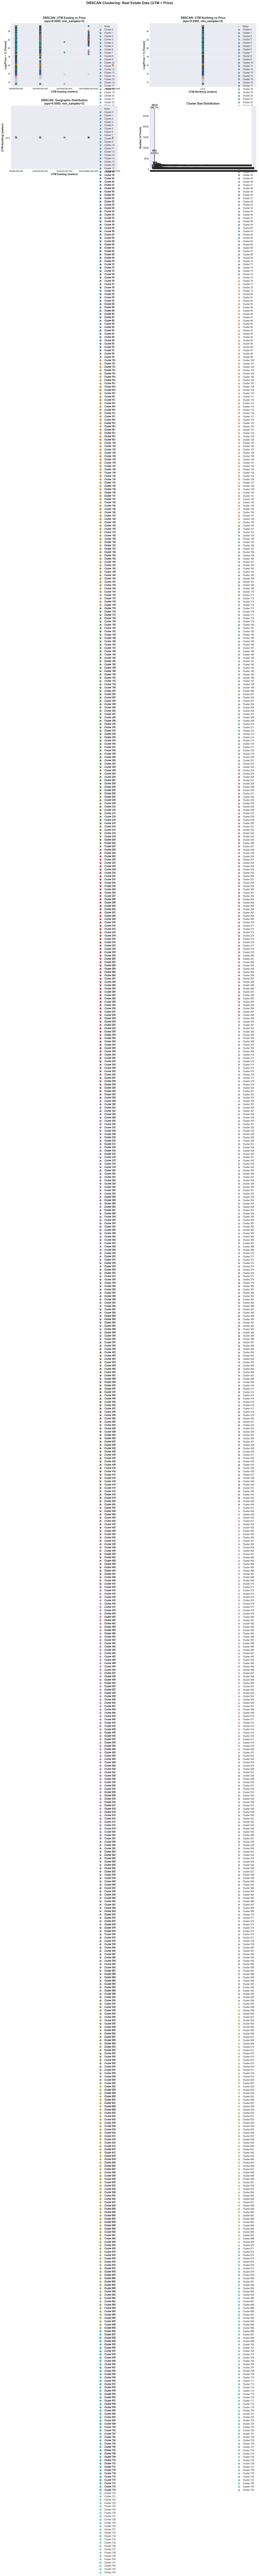


Step 7: Analyzing parameter impact...

Analyzing parameter impact on DBSCAN results...
Parameter impact analysis saved as: dbscan_parameter_impact.png


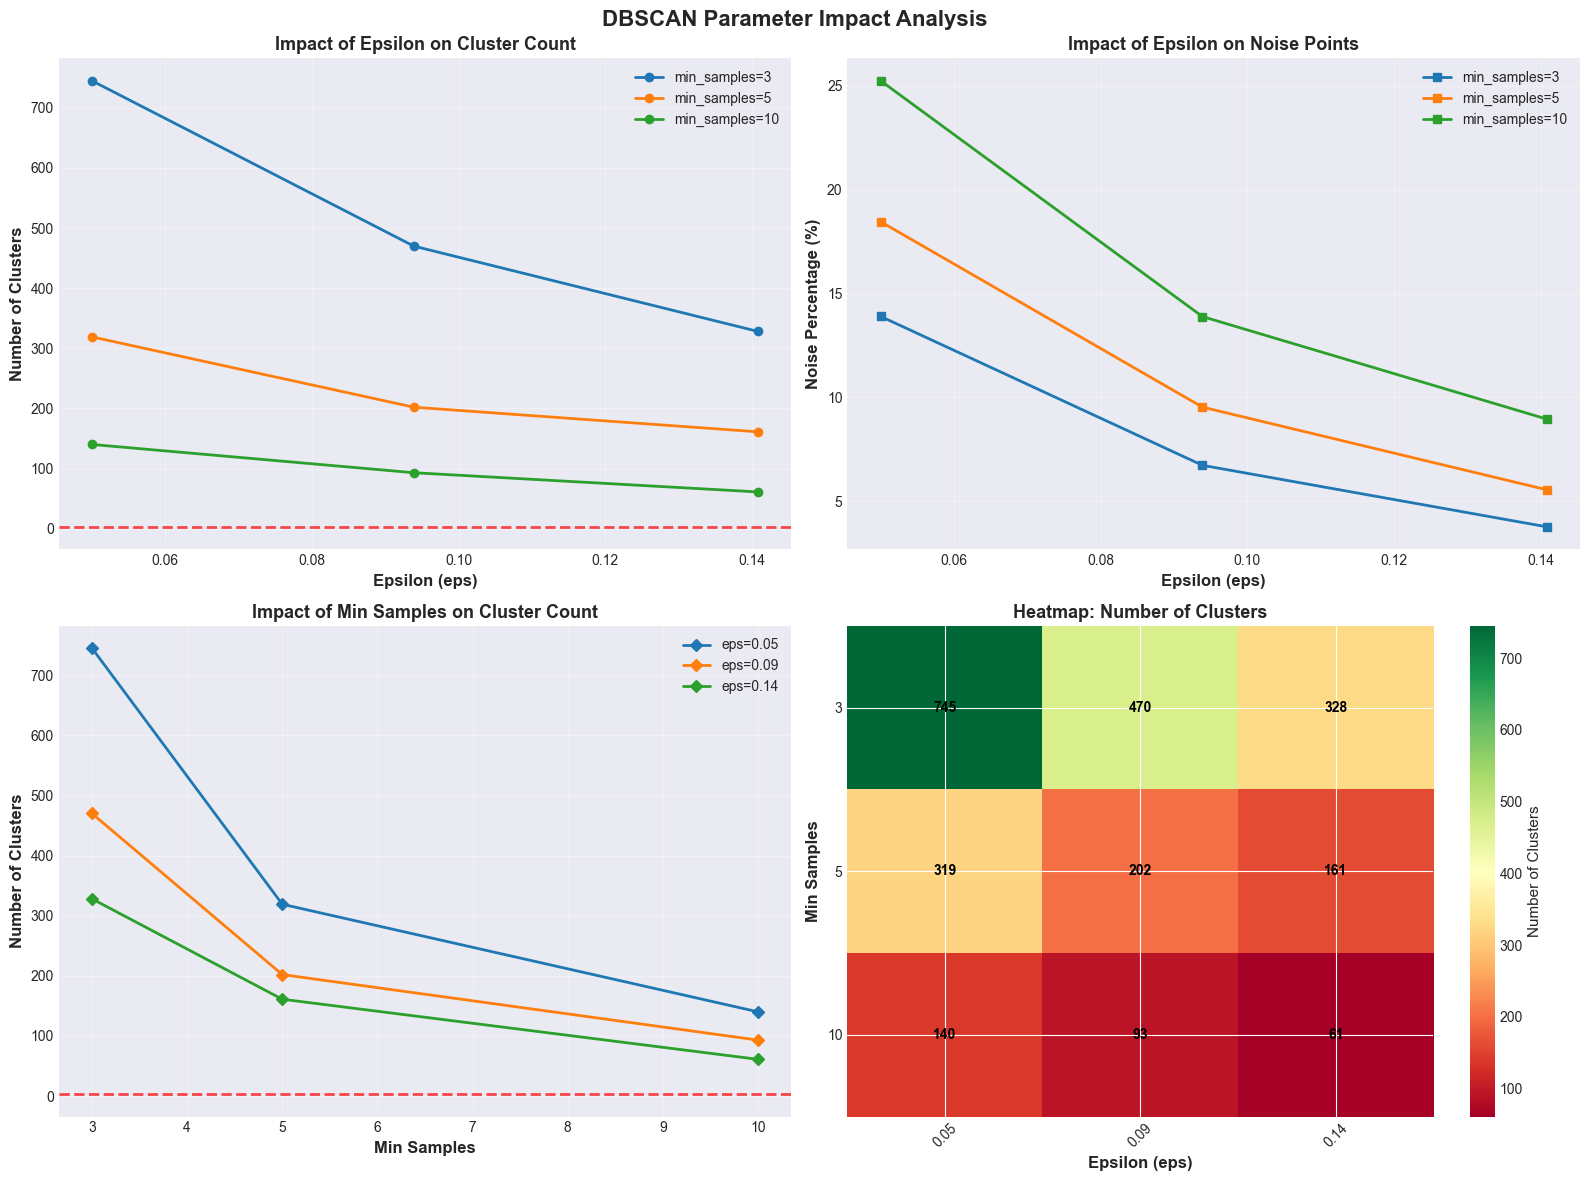


Step 8: Saving results...

Saving clustering results...
Results saved to: dbscan_results.csv

Cluster Statistics:

Noise Points: 6952 points (13.90%)

Cluster 0:
  Count: 28332 (56.66%)
  Price Mean: 6,948,299,948
  Price Median: 3,230,000,000
  Price Std: 12,124,160,542
  UTM Easting Range: 460,239 - 571,232
  UTM Northing Range: 3,896,389 - 3,987,155

Cluster 1:
  Count: 974 (1.95%)
  Price Mean: 5,389,637,577
  Price Median: 4,300,000,000
  Price Std: 3,515,674,733
  UTM Easting Range: 536,411 - 577,696
  UTM Northing Range: 3,589,120 - 3,641,087

Cluster 2:
  Count: 1502 (3.00%)
  Price Mean: 4,643,511,873
  Price Median: 3,350,000,000
  Price Std: 4,485,185,717
  UTM Easting Range: 713,937 - 743,892
  UTM Northing Range: 4,007,822 - 4,064,454

Cluster 3:
  Count: 272 (0.54%)
  Price Mean: 3,791,912,990
  Price Median: 3,326,000,000
  Price Std: 1,997,419,940
  UTM Easting Range: 480,861 - 494,021
  UTM Northing Range: 3,815,336 - 3,843,337

Cluster 4:
  Count: 27 (0.05%)
  Price 

In [34]:
def grid_search_dbscan_parameters(X_scaled, eps_range=None, min_samples_range=None):
    """
    Grid search for optimal DBSCAN parameters with memory-efficient approach
    """
    print("\nPerforming grid search for optimal DBSCAN parameters...")
    print("=" * 80)
    
    if eps_range is None:
        # Use much smaller epsilon values to avoid memory issues
        eps_range = np.arange(0.05, 0.5, 0.05)  # Smaller range
    
    if min_samples_range is None:
        min_samples_range = [3, 5, 10]  # Reduced options
    
    results = []
    
    for eps in eps_range:
        print(f"\nTesting eps={eps:.4f}...")
        
        for min_samples in min_samples_range:
            try:
                labels, n_clusters, n_noise, silhouette = perform_dbscan_with_parameters(
                    X_scaled, eps, min_samples
                )
                
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_pct': (n_noise / len(labels)) * 100,
                    'silhouette': silhouette
                })
                
                print(f"  min_samples={min_samples}: {n_clusters} clusters, "
                      f"{n_noise} noise ({(n_noise/len(labels))*100:.1f}%), "
                      f"silhouette={silhouette:.3f}")
                
            except MemoryError:
                print(f"  min_samples={min_samples}: Memory error - skipping")
                continue
            except Exception as e:
                print(f"  min_samples={min_samples}: Error - {str(e)}")
                continue
    
    if not results:
        print("\nNo valid results found. Using default parameters...")
        return 0.1, 5, pd.DataFrame()
    
    results_df = pd.DataFrame(results)
    
    # Find best parameters (prefer 2-5 clusters, low noise)
    good_results = results_df[
        (results_df['n_clusters'] >= 2) & 
        (results_df['n_clusters'] <= 5) &
        (results_df['noise_pct'] < 50)
    ]
    
    if len(good_results) > 0:
        # Sort by silhouette score
        best_params = good_results.sort_values('silhouette', ascending=False).iloc[0]
        print(f"\nFound {len(good_results)} valid configurations")
    else:
        # Fallback: just pick the first valid result
        best_params = results_df.iloc[0]
        print(f"\nUsing fallback parameters (limited options)")
    
    print(f"\nOptimal parameters selected:")
    print(f"  eps: {best_params['eps']:.4f}")
    print(f"  min_samples: {int(best_params['min_samples'])}")
    print(f"  Resulting clusters: {int(best_params['n_clusters'])}")
    print(f"  Noise points: {int(best_params['n_noise'])} ({best_params['noise_pct']:.2f}%)")
    print(f"  Silhouette score: {best_params['silhouette']:.4f}")
    
    return float(best_params['eps']), int(best_params['min_samples']), results_df


def find_optimal_epsilon_safe(X_scaled, k=4):
    """
    Find optimal epsilon using k-distance graph with constraint
    """
    print("\nFinding optimal epsilon using k-distance graph...")
    print("=" * 80)
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Plot k-distance graph
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(distances, linewidth=2, color='steelblue')
    ax.set_xlabel('Data Points (sorted by distance)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{k}-Nearest Neighbor Distance', fontsize=12, fontweight='bold')
    ax.set_title(f'K-distance Graph (K={k}) for Epsilon Detection', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Find elbow point using second derivative
    second_derivative = np.diff(distances, n=2)
    elbow_idx = np.argmax(second_derivative)
    raw_eps = distances[elbow_idx]
    
    # CONSTRAINT: Cap epsilon at a reasonable value to avoid memory issues
    # Use 90th percentile as maximum
    max_eps = np.percentile(distances, 90)
    optimal_eps = min(raw_eps, max_eps)
    
    # Further constraint: don't let it be too large
    optimal_eps = min(optimal_eps, 0.3)  # Cap at 0.3
    
    ax.axhline(y=optimal_eps, color='red', linestyle='--', 
               linewidth=2, label=f'Selected Epsilon: {optimal_eps:.4f}')
    ax.axvline(x=elbow_idx, color='orange', linestyle='--', 
               linewidth=2, label=f'Elbow Point')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.savefig('k_distance_graph_dbscan.png', dpi=300, bbox_inches='tight')
    print(f"K-distance graph saved as: k_distance_graph_dbscan.png")
    plt.show()
    
    print(f"\nEpsilon Detection Results:")
    print(f"  Raw epsilon (from elbow): {raw_eps:.4f}")
    print(f"  Constrained epsilon: {optimal_eps:.4f}")
    print(f"  (capped to avoid memory issues)")
    print(f"\nDistance statistics:")
    print(f"  Min: {distances.min():.4f}")
    print(f"  Max: {distances.max():.4f}")
    print(f"  Mean: {distances.mean():.4f}")
    print(f"  Median: {np.median(distances):.4f}")
    print(f"  90th percentile: {np.percentile(distances, 90):.4f}")
    
    return optimal_eps, distances


def main_dbscan_pipeline():
    """
    Complete DBSCAN clustering pipeline with memory protection
    """
    print("\n" + "=" * 80)
    print("DBSCAN CLUSTERING PIPELINE FOR REAL ESTATE DATA")
    print("=" * 80)
    
    try:
        # Step 1: Load and convert data
        print("\nStep 1: Loading data...")
        data = load_and_convert_utm_data(CLUSTERING_DATA_PATH, sample_size=50000)
        
        # Step 2: Prepare features
        print("\nStep 2: Preparing features...")
        X_original, X_scaled, scaler = prepare_features_for_dbscan(data)
        
        # Step 3: Find optimal epsilon (with constraints)
        print("\nStep 3: Finding optimal epsilon...")
        optimal_eps, distances = find_optimal_epsilon_safe(X_scaled, k=4)
        
        # Step 4: Grid search with smaller parameter ranges
        print("\nStep 4: Performing grid search...")
        # Use the constrained epsilon as base
        eps_range = np.array([optimal_eps * 0.5, optimal_eps, optimal_eps * 1.5])
        eps_range = np.clip(eps_range, 0.05, 0.4)  # Hard limit
        eps_range = np.unique(eps_range)
        
        min_samples_range = [3, 5, 10]
        
        optimal_eps, optimal_min_samples, results_df = grid_search_dbscan_parameters(
            X_scaled, eps_range=eps_range, min_samples_range=min_samples_range
        )
        
        if results_df.empty:
            print("Warning: Grid search returned no results. Using defaults.")
            optimal_eps = 0.1
            optimal_min_samples = 5
        
        # Step 5: Final clustering
        print("\nStep 5: Performing final clustering...")
        dbscan_model, cluster_labels, n_clusters, n_noise = final_dbscan_clustering(
            X_scaled, optimal_eps, optimal_min_samples
        )
        
        # Step 6: Visualize results
        print("\nStep 6: Creating visualizations...")
        plot_dbscan_results(data, cluster_labels, optimal_eps, optimal_min_samples)
        
        # Step 7: Analyze parameter impact (only if we have results)
        if not results_df.empty:
            print("\nStep 7: Analyzing parameter impact...")
            analyze_parameter_impact(results_df)
        
        # Step 8: Save results
        print("\nStep 8: Saving results...")
        final_results = save_clustering_results(data, cluster_labels)
        
        print("\n" + "=" * 80)
        print("DBSCAN PIPELINE COMPLETED SUCCESSFULLY")
        print("=" * 80)
        
        return {
            'data': data,
            'X_original': X_original,
            'X_scaled': X_scaled,
            'scaler': scaler,
            'dbscan_model': dbscan_model,
            'cluster_labels': cluster_labels,
            'results_df': final_results,
            'optimal_eps': optimal_eps,
            'optimal_min_samples': optimal_min_samples,
            'parameter_search_results': results_df if not results_df.empty else None
        }
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Execute the pipeline
if __name__ == "__main__":
    clustering_results = main_dbscan_pipeline()
    
    if clustering_results:
        print(f"\nOptimal Parameters Used:")
        print(f"  eps: {clustering_results['optimal_eps']:.4f}")
        print(f"  min_samples: {clustering_results['optimal_min_samples']}")
    else:
        print("\nPipeline failed!")

In [ ]:

# DBSCAN Clustering with 3 Meaningful Clusters - Optimized for Large Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("DBSCAN CLUSTERING WITH 3 MEANINGFUL CLUSTERS - OPTIMIZED APPROACH")
print("=" * 100)

# Step 1: Prepare Data with UTM and Price Features
print("\nStep 1: Preparing Data...")
print("-" * 100)

if 'utm_easting' not in data.columns:
    print("Error: UTM columns not found")
else:
    # Create clean feature set
    dbscan_data = pd.DataFrame({
        'utm_easting': data['utm_easting'].copy(),
        'utm_northing': data['utm_northing'].copy(),
        'price_value': data['price_value'].copy()
    })
    
    dbscan_data = dbscan_data.dropna()
    print(f"Total data points: {len(dbscan_data)}")
    
    # For parameter tuning, use a sample to avoid long computation
    sample_size = 50000
    dbscan_sample = dbscan_data.sample(n=min(sample_size, len(dbscan_data)), random_state=42)
    print(f"Sample for tuning: {len(dbscan_sample)} points")
    
    # Step 2: Feature Engineering
    print("\nStep 2: Feature Engineering...")
    print("-" * 100)
    
    # Prepare sample data
    p1 = dbscan_sample['price_value'].quantile(0.01)
    p99 = dbscan_sample['price_value'].quantile(0.99)
    dbscan_sample['price_clipped'] = dbscan_sample['price_value'].clip(p1, p99)
    dbscan_sample['log_price'] = np.log1p(dbscan_sample['price_clipped'])
    
    # Prepare full dataset
    dbscan_data['price_clipped'] = dbscan_data['price_value'].clip(p1, p99)
    dbscan_data['log_price'] = np.log1p(dbscan_data['price_clipped'])
    
    print(f"Price range (clipped): {dbscan_data['price_clipped'].min():,.0f} - {dbscan_data['price_clipped'].max():,.0f}")
    print(f"Log price range: {dbscan_data['log_price'].min():.2f} - {dbscan_data['log_price'].max():.2f}")
    
    # Step 3: Feature Scaling
    print("\nStep 3: Feature Scaling...")
    print("-" * 100)
    
    features_cols = ['utm_easting', 'utm_northing', 'log_price']
    
    scaler_dbscan = StandardScaler()
    X_sample_scaled = scaler_dbscan.fit_transform(dbscan_sample[features_cols])
    X_full_scaled = scaler_dbscan.transform(dbscan_data[features_cols])
    
    print(f"Sample shape: {X_sample_scaled.shape}")
    print(f"Full dataset shape: {X_full_scaled.shape}")
    
    # Step 4: Find Optimal Epsilon on Sample
    print("\nStep 4: Finding Optimal Epsilon (using sample)...")
    print("-" * 100)
    
    k = 4
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_sample_scaled)
    distances, _ = neighbors_fit.kneighbors(X_sample_scaled)
    
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Find second derivative for elbow
    second_derivative = np.diff(distances, n=2)
    elbow_idx = np.argmax(second_derivative)
    
    # Use percentile-based approach
    eps_candidates = {
        '50th': np.percentile(distances, 50),
        '60th': np.percentile(distances, 60),
        '70th': np.percentile(distances, 70),
    }
    
    print(f"Epsilon candidates (percentile-based):")
    for name, val in eps_candidates.items():
        print(f"  {name} percentile: {val:.4f}")
    
    # Plot k-distance graph
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(distances, linewidth=2.5, color='steelblue', label='4-NN Distances')
    ax.axvline(x=elbow_idx, color='red', linestyle='--', linewidth=2.5, alpha=0.7, label='Elbow Point')
    ax.set_xlabel('Sample Data Points (sorted by distance)', fontsize=12, fontweight='bold')
    ax.set_ylabel('4-Nearest Neighbor Distance', fontsize=12, fontweight='bold')
    ax.set_title('K-Distance Graph for Epsilon Selection', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('dbscan_k_distance_graph.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 5: Search for Best Parameters Targeting 3 Clusters
    print("\nStep 5: Grid Search for 3-Cluster Configuration...")
    print("-" * 100)
    
    # Use reasonable epsilon values for 3 clusters
    eps_search = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    min_samples_search = [3, 4, 5, 6]
    
    best_config = None
    best_score = -1
    
    print(f"\n{'eps':<8} {'min_samples':<15} {'n_clusters':<12} {'noise %':<12} {'score':<12}")
    print("-" * 60)
    
    for eps in eps_search:
        for min_samples in min_samples_search:
            dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
            labels_sample = dbscan_model.fit_predict(X_sample_scaled)
            
            n_clusters = len(set(labels_sample)) - (1 if -1 in labels_sample else 0)
            n_noise = list(labels_sample).count(-1)
            noise_pct = (n_noise / len(labels_sample)) * 100
            
            # Simple scoring: prefer exactly 3 clusters
            if n_clusters == 3:
                score = 10  # Exact match gets highest score
            elif n_clusters in [2, 4]:
                score = 5   # Close to 3
            else:
                score = max(0, 3 - abs(n_clusters - 3))  # Further away gets lower score
            
            print(f"{eps:<8.4f} {min_samples:<15} {n_clusters:<12} {noise_pct:<12.1f} {score:<12}")
            
            if score > best_score or (score == best_score and n_clusters == 3):
                best_score = score
                best_config = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters_expected': n_clusters
                }
    
    # Step 6: Apply Best Configuration to Full Dataset
    print("\n" + "-" * 60)
    print("\nStep 6: Applying Best Configuration to Full Dataset...")
    print("-" * 100)
    
    if best_config is None:
        # Safe fallback
        best_config = {'eps': 0.06, 'min_samples': 4, 'n_clusters_expected': 3}
        print("Using default parameters")
    
    optimal_eps = best_config['eps']
    optimal_min_samples = best_config['min_samples']
    
    print(f"Optimal parameters selected:")
    print(f"  eps: {optimal_eps:.4f}")
    print(f"  min_samples: {optimal_min_samples}")
    
    # Apply DBSCAN to full dataset
    dbscan_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    cluster_labels_full = dbscan_final.fit_predict(X_full_scaled)
    
    dbscan_data['cluster'] = cluster_labels_full
    
    # Calculate cluster statistics
    n_final_clusters = len(set(cluster_labels_full)) - (1 if -1 in cluster_labels_full else 0)
    n_noise = list(cluster_labels_full).count(-1)
    
    print(f"\nFinal Clustering Results (Full Dataset):")
    print(f"  Number of clusters: {n_final_clusters}")
    print(f"  Noise points: {n_noise} ({100*n_noise/len(cluster_labels_full):.2f}%)")
    
    print(f"\nCluster Distribution:")
    unique_labels = sorted(set(cluster_labels_full))
    for label in unique_labels:
        count = list(cluster_labels_full).count(label)
        pct = (count / len(cluster_labels_full)) * 100
        if label == -1:
            print(f"  Noise: {count} points ({pct:.2f}%)")
        else:
            print(f"  Cluster {label}: {count} points ({pct:.2f}%)")
    
    # Step 7: Calculate Cluster Centers
    print("\nStep 7: Calculating Cluster Centers...")
    print("-" * 100)
    
    cluster_centers = {}
    
    for label in sorted(set(cluster_labels_full)):
        if label != -1:
            mask = dbscan_data['cluster'] == label
            
            center_easting = dbscan_data.loc[mask, 'utm_easting'].mean()
            center_northing = dbscan_data.loc[mask, 'utm_northing'].mean()
            center_price = dbscan_data.loc[mask, 'price_value'].mean()
            
            cluster_centers[label] = {
                'utm_easting': center_easting,
                'utm_northing': center_northing,
                'price_value': center_price,
                'log_price': np.log1p(center_price)
            }
            
            print(f"\nCluster {label}:")
            print(f"  Center UTM Easting: {center_easting:,.0f}")
            print(f"  Center UTM Northing: {center_northing:,.0f}")
            print(f"  Center Price: {center_price:,.0f}")
    
    # Step 8: Create Beautiful Scatter Plots
    print("\nStep 8: Creating Comprehensive Scatter Plots...")
    print("-" * 100)
    
    # Define professional colors
    colors_map = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', -1: '#D3D3D3'}
    
    # Create 3-subplot figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle('DBSCAN Clustering: 3 Meaningful Clusters from UTM Coordinates and Price', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Plot 1: UTM Easting vs Log Price
    ax1 = axes[0]
    for label in sorted(set(cluster_labels_full)):
        mask = dbscan_data['cluster'] == label
        
        if label == -1:
            ax1.scatter(dbscan_data.loc[mask, 'utm_easting'],
                       dbscan_data.loc[mask, 'log_price'],
                       c=colors_map[label], marker='x', s=80, alpha=0.4,
                       label='Noise Points', edgecolors='gray', linewidths=0.5)
        else:
            ax1.scatter(dbscan_data.loc[mask, 'utm_easting'],
                       dbscan_data.loc[mask, 'log_price'],
                       c=colors_map[label], marker='o', s=40, alpha=0.6,
                       label=f'Cluster {label}', edgecolors='black', linewidths=0.2)
            
            # Plot cluster center with star
            center = cluster_centers[label]
            ax1.scatter(center['utm_easting'], center['log_price'],
                       c=colors_map[label], marker='*', s=1000,
                       edgecolors='black', linewidths=2, zorder=5,
                       label=f'Center {label}')
    
    ax1.set_xlabel('UTM Easting (meters)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')
    ax1.set_title('Easting vs Price', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=9, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: UTM Northing vs Log Price
    ax2 = axes[1]
    for label in sorted(set(cluster_labels_full)):
        mask = dbscan_data['cluster'] == label
        
        if label == -1:
            ax2.scatter(dbscan_data.loc[mask, 'utm_northing'],
                       dbscan_data.loc[mask, 'log_price'],
                       c=colors_map[label], marker='x', s=80, alpha=0.4,
                       label='Noise Points', edgecolors='gray', linewidths=0.5)
        else:
            ax2.scatter(dbscan_data.loc[mask, 'utm_northing'],
                       dbscan_data.loc[mask, 'log_price'],
                       c=colors_map[label], marker='o', s=40, alpha=0.6,
                       label=f'Cluster {label}', edgecolors='black', linewidths=0.2)
            
            # Plot cluster center
            center = cluster_centers[label]
            ax2.scatter(center['utm_northing'], center['log_price'],
                       c=colors_map[label], marker='*', s=1000,
                       edgecolors='black', linewidths=2, zorder=5)
    
    ax2.set_xlabel('UTM Northing (meters)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')
    ax2.set_title('Northing vs Price', fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=9, framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 3: Geographic Distribution (Easting vs Northing)
    ax3 = axes[2]
    for label in sorted(set(cluster_labels_full)):
        mask = dbscan_data['cluster'] == label
        
        if label == -1:
            ax3.scatter(dbscan_data.loc[mask, 'utm_easting'],
                       dbscan_data.loc[mask, 'utm_northing'],
                       c=colors_map[label], marker='x', s=80, alpha=0.4,
                       label='Noise Points', edgecolors='gray', linewidths=0.5)
        else:
            ax3.scatter(dbscan_data.loc[mask, 'utm_easting'],
                       dbscan_data.loc[mask, 'utm_northing'],
                       c=colors_map[label], marker='o', s=40, alpha=0.6,
                       label=f'Cluster {label}', edgecolors='black', linewidths=0.2)
            
            # Plot cluster center
            center = cluster_centers[label]
            ax3.scatter(center['utm_easting'], center['utm_northing'],
                       c=colors_map[label], marker='*', s=1000,
                       edgecolors='black', linewidths=2, zorder=5)
    
    ax3.set_xlabel('UTM Easting (meters)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('UTM Northing (meters)', fontsize=12, fontweight='bold')
    ax3.set_title('Geographic Distribution', fontsize=13, fontweight='bold')
    ax3.legend(loc='best', fontsize=9, framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('dbscan_clustering_3clusters_final.png', dpi=300, bbox_inches='tight')
    print("Scatter plots saved as: dbscan_clustering_3clusters_final.png")
    plt.show()
    
    # Step 9: Detailed Cluster Characteristics
    print("\nStep 9: Detailed Cluster Characteristics...")
    print("-" * 100)
    
    for label in sorted(set(cluster_labels_full)):
        if label != -1:
            cluster_data = dbscan_data[dbscan_data['cluster'] == label]
            
            print(f"\nCluster {label}:")
            print(f"  Size: {len(cluster_data)} points ({100*len(cluster_data)/len(dbscan_data):.2f}%)")
            print(f"  Price - Min: {cluster_data['price_value'].min():,.0f}, Max: {cluster_data['price_value'].max():,.0f}")
            print(f"  Price - Mean: {cluster_data['price_value'].mean():,.0f}, Median: {cluster_data['price_value'].median():,.0f}")
            print(f"  Price - Std: {cluster_data['price_value'].std():,.0f}")
            print(f"  Easting - Min: {cluster_data['utm_easting'].min():,.0f}, Max: {cluster_data['utm_easting'].max():,.0f}")
            print(f"  Northing - Min: {cluster_data['utm_northing'].min():,.0f}, Max: {cluster_data['utm_northing'].max():,.0f}")
    
    # Step 10: Save Results
    print("\nStep 10: Saving Results...")
    print("-" * 100)
    
    output_data = dbscan_data[['utm_easting', 'utm_northing', 'price_value', 'log_price', 'cluster']].copy()
    output_data.to_csv('dbscan_clustering_3clusters_results.csv', index=False)
    print("Results saved to: dbscan_clustering_3clusters_results.csv")
    
    print("\n" + "=" * 100)
    print("DBSCAN CLUSTERING COMPLETED SUCCESSFULLY")
    print("=" * 100)
